<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Endpoints300s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Data

In [2]:
dataset_e1 = load_dataset("anastasiafrosted/endpoint0_300", download_mode="force_redownload")
dataset_e2 = load_dataset("anastasiafrosted/endpoint1_300", download_mode="force_redownload")

df_1 = pd.DataFrame(dataset_e1['train'])
df_2 = pd.DataFrame(dataset_e2['train'])

# Ensure the `timestamp` column is in datetime format
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])
df_2['timestamp'] = pd.to_datetime(df_2['timestamp'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/850 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/629k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25600 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/850 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/327k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22019 [00:00<?, ? examples/s]

In [3]:
data1 = df_1
data1 = data1.set_index("timestamp")
data2 = df_2
data2 = data2.set_index("timestamp")
freq='300s'

In [4]:
origin = "2023-06-15"
start = "2023-07-02" # origin + prediction_lenght
end = "2023-07-08"

train_data1 = data1["2022-12-20":origin]
valid_data1 = data1[origin:start]
test_data1 = data1[start:]

train_data2 = data2["2022-12-20":origin]
valid_data2 = data2[origin:start]
test_data2 = data2[start:]

# List of columns to drop
columns_to_drop = [
    'e_type_LSFProvider', 'e_type_CobaltProvider',
    'e_type_PBSProProvider', 'e_type_LocalProvider',
    'e_type_KubernetesProvider', 'e_type_SlurmProvider'
]
train_data1 = train_data1.drop(columns=columns_to_drop, errors='ignore')
valid_data1 = valid_data1.drop(columns=columns_to_drop, errors='ignore')
test_data1 = test_data1.drop(columns=columns_to_drop, errors='ignore')

train_data2 = train_data2.drop(columns=columns_to_drop, errors='ignore')
valid_data2 = valid_data2.drop(columns=columns_to_drop, errors='ignore')
test_data2 = test_data2.drop(columns=columns_to_drop, errors='ignore')

#### Scaling

In [5]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

In [6]:
# ENDPOINT 1:

# Per il dataset di training
scaled_train1 = train_data1.copy()
scaled_train1[scaled_train1.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data1[train_data1.columns.drop('avg_invocations_rate')]
)
train1 = scaled_train1

# Per il dataset di validazione
scaled_valid1 = valid_data1.copy()
scaled_valid1[scaled_valid1.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data1[valid_data1.columns.drop('avg_invocations_rate')]
)
valid1 = scaled_valid1

# Per il dataset di test
scaled_test1 = test_data1.copy()
scaled_test1[scaled_test1.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data1[test_data1.columns.drop('avg_invocations_rate')]
)
test1 = scaled_test1

In [7]:
# ENDPOINT 2:

# Per il dataset di training
scaled_train2 = train_data2.copy()
scaled_train2[scaled_train2.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data2[train_data2.columns.drop('avg_invocations_rate')]
)
train2 = scaled_train2

# Per il dataset di validazione
scaled_valid2 = valid_data2.copy()
scaled_valid2[scaled_valid2.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data2[valid_data2.columns.drop('avg_invocations_rate')]
)
valid2 = scaled_valid2

# Per il dataset di test
scaled_test2 = test_data2.copy()
scaled_test2[scaled_test2.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data2[test_data2.columns.drop('avg_invocations_rate')]
)
test2 = scaled_test2

#### Config (Parameters)

In [8]:
batch_size = 32
num_features = 6
sequence_lenght = 7
prediction_lenght = 7

seed = 123
neurons = 32
epochs = 10

# Models

## Forecasting one-step-ahead

In [9]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [10]:
tr1 = train1['avg_invocations_rate']
vl1 = valid1['avg_invocations_rate']
ts1 = test1['avg_invocations_rate'][:-1]

tr2 = train2['avg_invocations_rate']
vl2 = valid2['avg_invocations_rate']
ts2 = test2['avg_invocations_rate'][:-1]

In [11]:
# ENDPOINT 1:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    tr1.to_numpy(),
    targets=tr1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    vl1.to_numpy(),
    targets=vl1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    ts1.to_numpy(),
    targets=ts1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

In [12]:
# ENDPOINT 2:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    tr2.to_numpy(),
    targets=tr2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    vl2.to_numpy(),
    targets=vl2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    ts2.to_numpy(),
    targets=ts2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
fit_and_evaluate(model, train_ds1, valid_ds1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0041 - mae: 0.0700 - val_loss: 0.0014 - val_mae: 0.0452
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0012 - mae: 0.0393 - val_loss: 7.0688e-04 - val_mae: 0.0305
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 6.9665e-04 - mae: 0.0290 - val_loss: 5.0703e-04 - val_mae: 0.0244
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 5.4956e-04 - mae: 0.0248 - val_loss: 4.3491e-04 - val_mae: 0.0216
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 4.8894e-04 - mae: 0.0228 - val_loss: 3.9057e-04 - val_mae: 0.0201
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 4.5487e-04 - mae: 0.0218 - val_loss: 3.6215e-04 - val_mae: 0.0191
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 4.3036e-04 - mae: 0.0210 - val_loss: 3.3699e-04 - val_mae: 0.0184
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 4.1034e-04 - mae: 0.0204 - val_loss: 3.1741e-04 - val_mae: 0.017

16754.120588302612

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


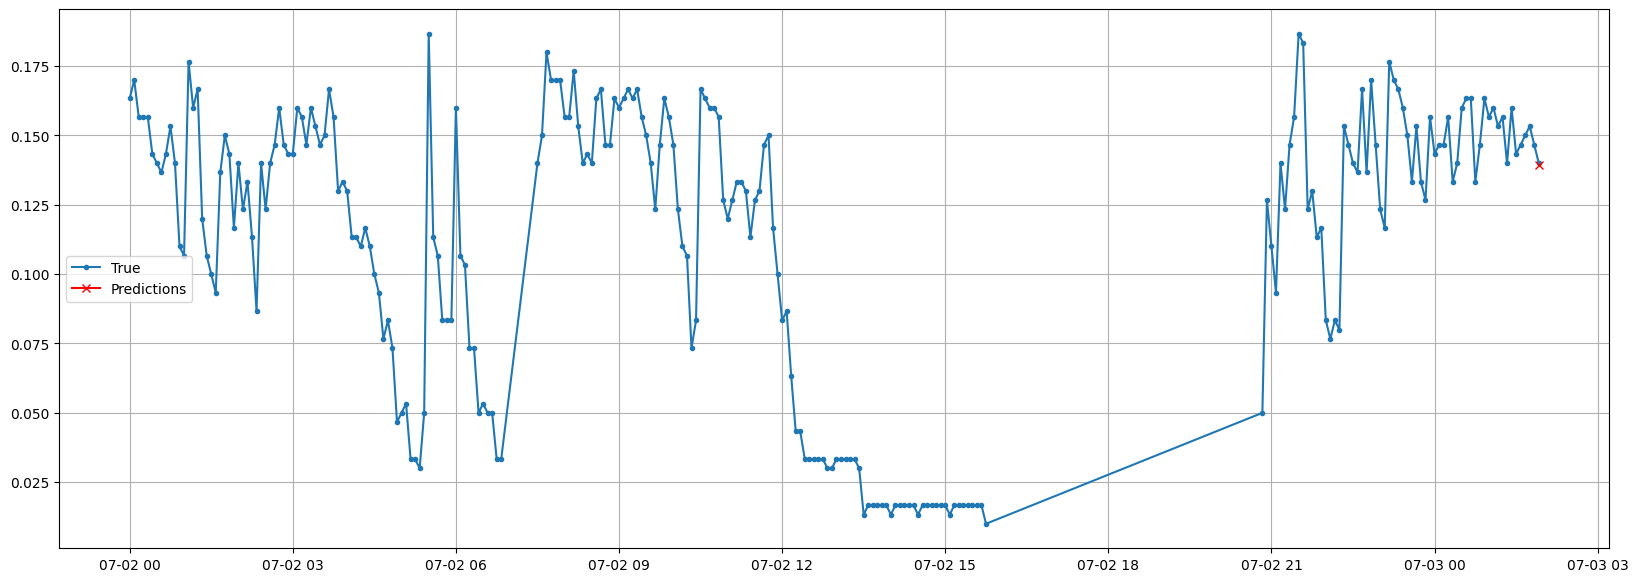

In [15]:
Y_pred = model.predict(test_ds1)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test1.index[-1], end=test1.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [16]:
fit_and_evaluate(model, train_ds2, valid_ds2)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.6171e-04 - mae: 0.0075 - val_loss: 3.0222e-05 - val_mae: 0.0049
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.5598e-04 - mae: 0.0074 - val_loss: 2.9996e-05 - val_mae: 0.0049
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 2.5603e-04 - mae: 0.0074 - val_loss: 2.9905e-05 - val_mae: 0.0049
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.4521e-04 - mae: 0.0073 - val_loss: 3.0542e-05 - val_mae: 0.0050
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.4908e-04 - mae: 0.0073 - val_loss: 2.8937e-05 - val_mae: 0.0049
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 2.4587e-04 - mae: 0.0072 - val_loss: 3.0229e-05 - val_mae: 0.0050
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.3976e-04 - mae: 0.0071 - val_loss: 2.9151e-05 - val_mae: 0.0049
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.3999e-04 - mae: 0.0071 - val_loss: 2.9828e-05 - val_mae:

4920.413251966238

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


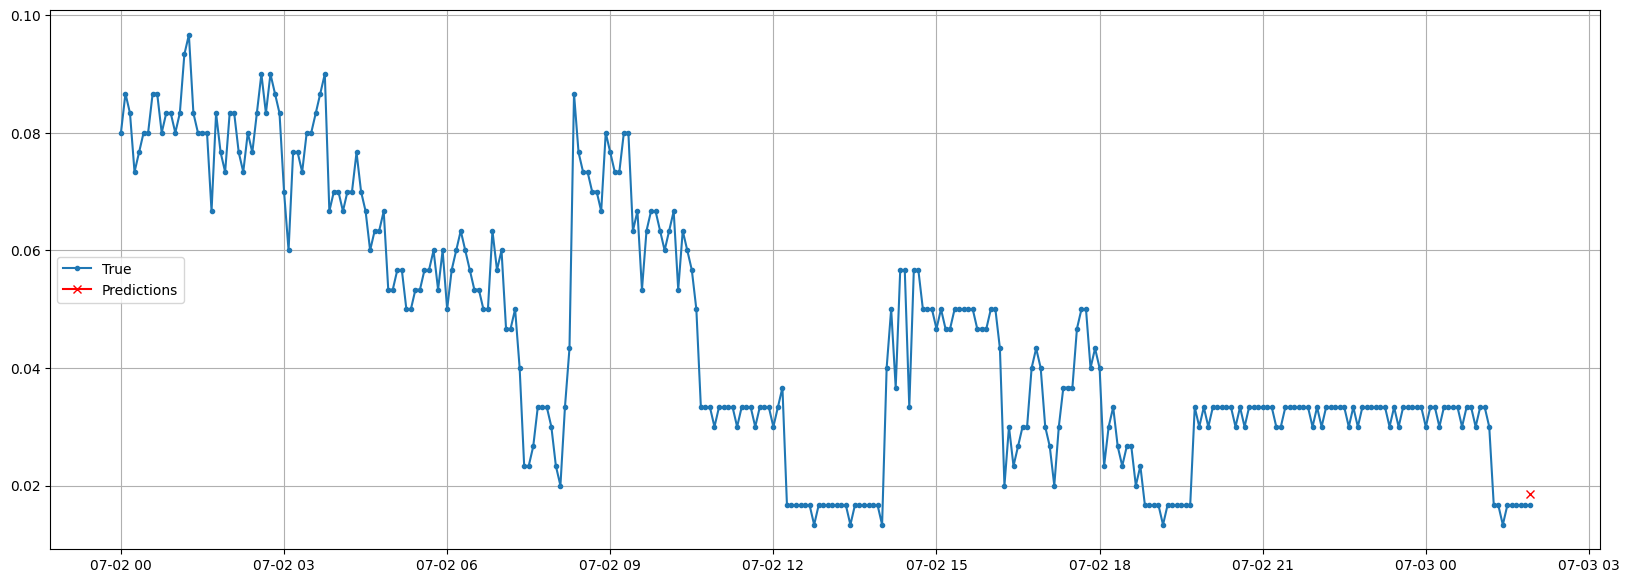

In [17]:
Y_pred = model.predict(test_ds2)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test2.index[-1], end=test2.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [18]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
fit_and_evaluate(univar_model, train_ds1, valid_ds1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 6.9942e-04 - mae: 0.0270 - val_loss: 3.0288e-04 - val_mae: 0.0167
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 3.4703e-04 - mae: 0.0194 - val_loss: 2.4549e-04 - val_mae: 0.0154
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3.1767e-04 - mae: 0.0182 - val_loss: 2.3084e-04 - val_mae: 0.0144
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.0179e-04 - mae: 0.0176 - val_loss: 2.1794e-04 - val_mae: 0.0150
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 2.9543e-04 - mae: 0.0174 - val_loss: 2.0980e-04 - val_mae: 0.0140
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.9176e-04 - mae: 0.0172 - val_loss: 2.2132e-04 - val_mae: 0.0135
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 2.8682e-04 - mae: 0.0170 - val_loss: 2.3838e-04 - val_mae: 0.0172
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2.8173e-04 - mae: 0.0169 - val_loss: 2.0247e-04 - val_m

13038.587756454945

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


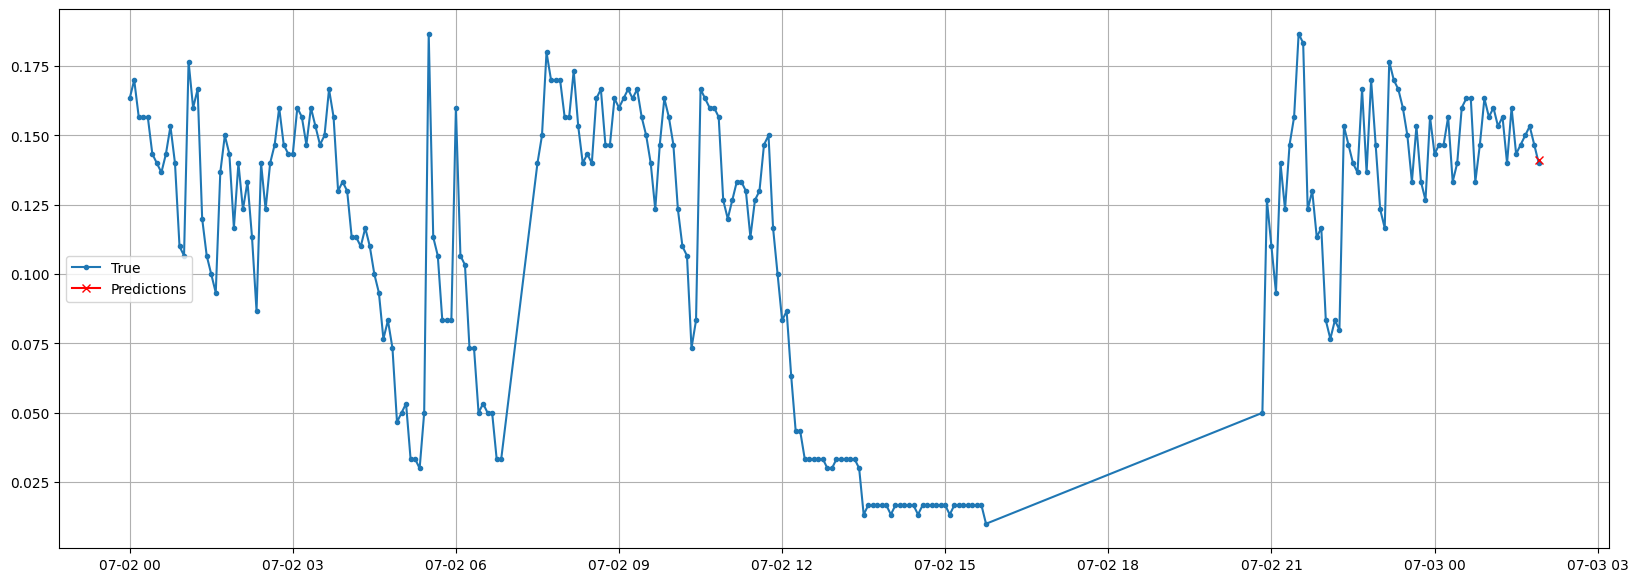

In [20]:
Y_pred = univar_model.predict(test_ds1)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test1.index[-1], end=test1.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [21]:
fit_and_evaluate(univar_model, train_ds2, valid_ds2)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 2.1408e-04 - mae: 0.0072 - val_loss: 2.5519e-05 - val_mae: 0.0047
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.0991e-04 - mae: 0.0070 - val_loss: 2.7997e-05 - val_mae: 0.0048
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.0751e-04 - mae: 0.0070 - val_loss: 2.4197e-05 - val_mae: 0.0050
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 2.0487e-04 - mae: 0.0067 - val_loss: 2.6593e-05 - val_mae: 0.0048
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.9874e-04 - mae: 0.0067 - val_loss: 2.4148e-05 - val_mae: 0.0049
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.0265e-04 - mae: 0.0068 - val_loss: 2.6384e-05 - val_mae: 0.0047
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.0091e-04 - mae: 0.0069 - val_loss: 2.4682e-05 - val_mae: 0.0047
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.0378e-04 - mae: 0.0070 - val_loss: 2.4953e-05 - val_m

4632.085561752319

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


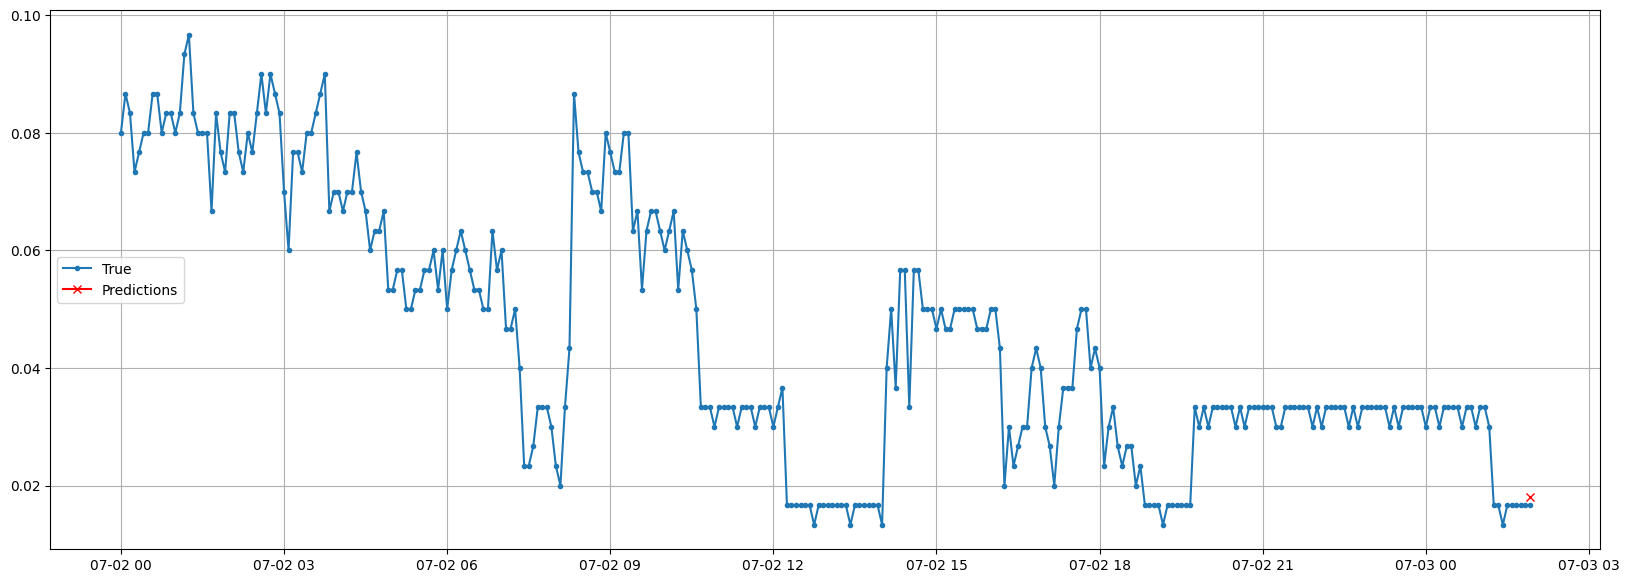

In [22]:
Y_pred = univar_model.predict(test_ds2)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test2.index[-1], end=test2.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Deep RNN

In [23]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons*3, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True),
    tf.keras.layers.SimpleRNN(neurons),
    tf.keras.layers.Dense(1)
])

In [24]:
fit_and_evaluate(deep_model, train_ds1, valid_ds1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0011 - mae: 0.0299 - val_loss: 3.4601e-04 - val_mae: 0.0187
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 3.4632e-04 - mae: 0.0195 - val_loss: 4.6333e-04 - val_mae: 0.0237
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 3.3324e-04 - mae: 0.0190 - val_loss: 2.0859e-04 - val_mae: 0.0142
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 3.0279e-04 - mae: 0.0179 - val_loss: 2.9613e-04 - val_mae: 0.0172
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 2.9577e-04 - mae: 0.0178 - val_loss: 2.0225e-04 - val_mae: 0.0130
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 2.8923e-04 - mae: 0.0173 - val_loss: 1.9523e-04 - val_mae: 0.0128
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.8603e-04 - mae: 0.0172 - val_loss: 1.9272e-04 - val_mae: 0.0140
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 2.7792e-04 - mae: 0.0169 - val_loss: 2.0895e-04 

12820.2885389328

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


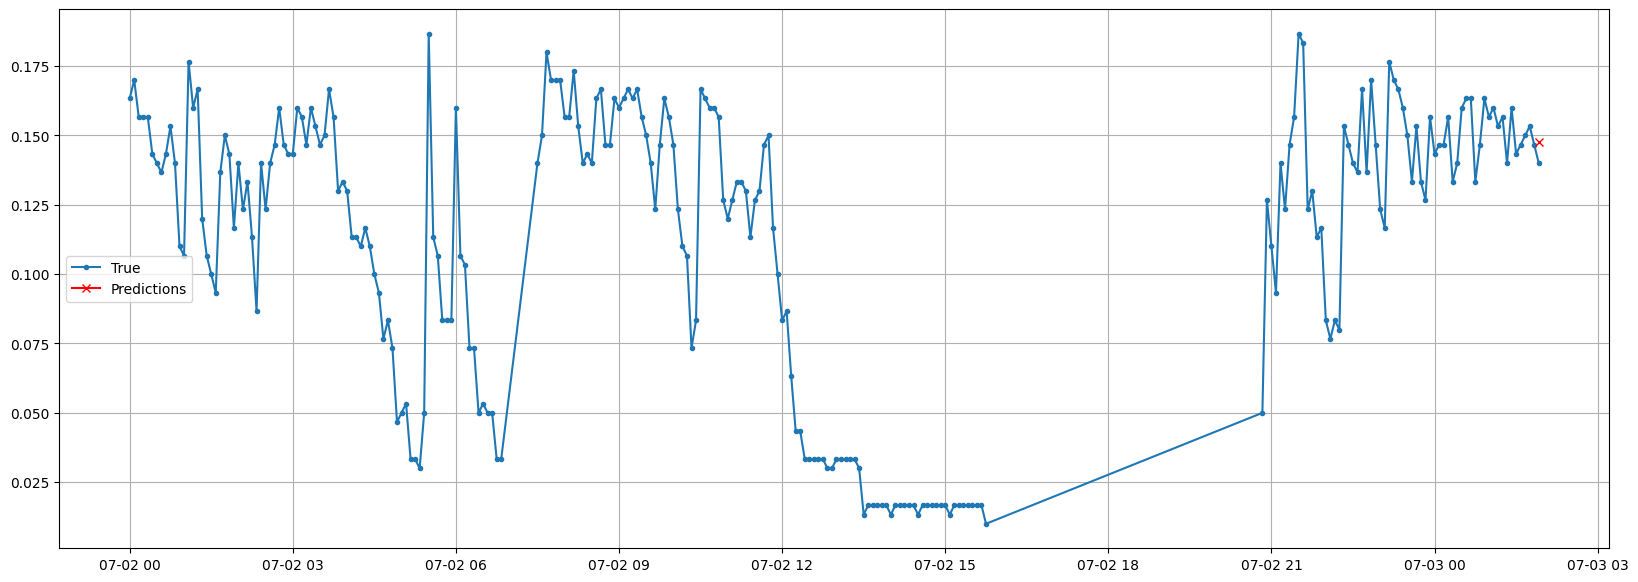

In [25]:
Y_pred = deep_model.predict(test_ds1)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test1.index[-1], end=test1.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [26]:
fit_and_evaluate(deep_model, train_ds2, valid_ds2)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 2.1374e-04 - mae: 0.0079 - val_loss: 2.9466e-05 - val_mae: 0.0051
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 2.0773e-04 - mae: 0.0082 - val_loss: 2.4755e-05 - val_mae: 0.0046
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 2.0520e-04 - mae: 0.0083 - val_loss: 2.3706e-05 - val_mae: 0.0053
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.0808e-04 - mae: 0.0088 - val_loss: 3.4807e-05 - val_mae: 0.0061
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 2.0736e-04 - mae: 0.0088 - val_loss: 2.1482e-05 - val_mae: 0.0046
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 1.9755e-04 - mae: 0.0080 - val_loss: 2.7646e-05 - val_mae: 0.0060
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 2.0601e-04 - mae: 0.0087 - val_loss: 3.0861e-05 - val_mae: 0.0057
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 2.0035e-04 - mae: 0.0085 - val_loss: 2.6744e

4469.545558094978

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


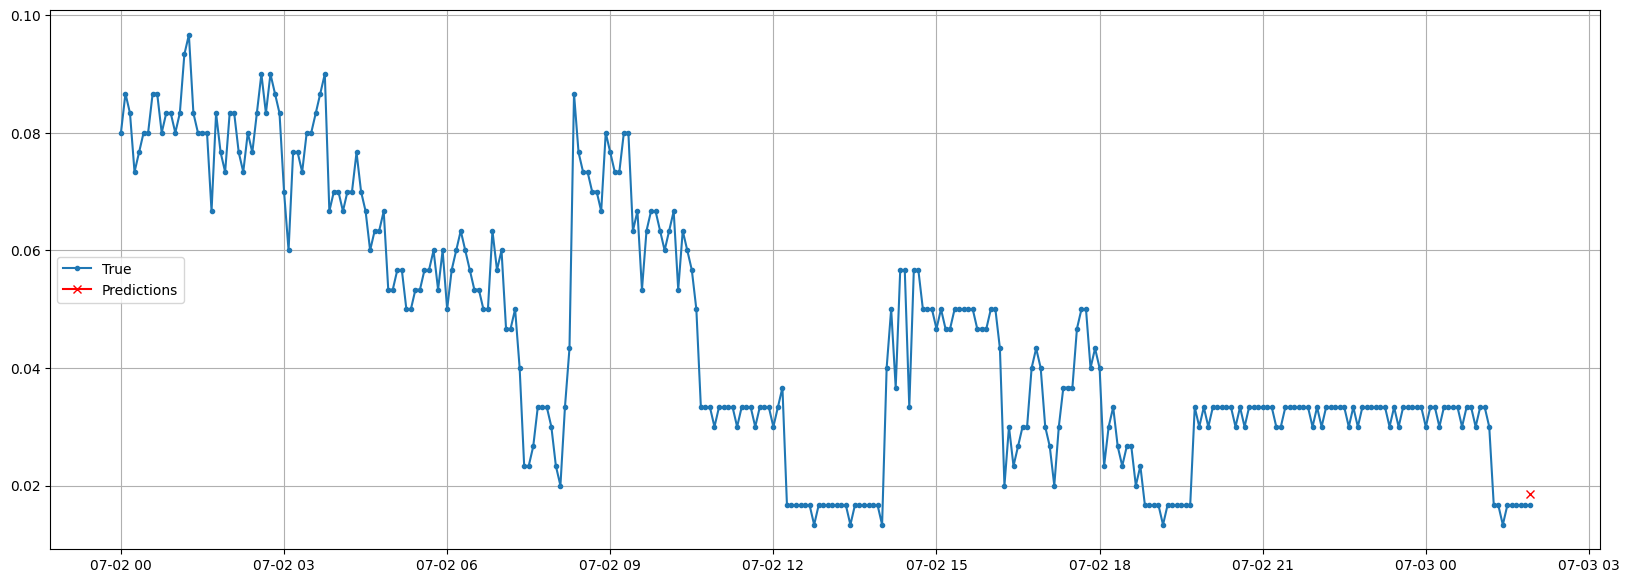

In [27]:
Y_pred = deep_model.predict(test_ds2)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test2.index[-1], end=test2.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

### Multivariate Series

In [28]:
# ENDPOINT 1:

tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    train1,
    targets=train1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    valid1,
    targets=valid1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    test1,
    targets=test1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

In [29]:
# ENDPOINT 2:

tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    train2,
    targets=train2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    valid2,
    targets=valid2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    test2,
    targets=test2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [30]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
fit_and_evaluate(mulvar_model, train_mulvar_ds1, valid_mulvar_ds1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0137 - mae: 0.0960 - val_loss: 6.9356e-04 - val_mae: 0.0269
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 8.4168e-04 - mae: 0.0294 - val_loss: 4.2034e-04 - val_mae: 0.0201
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 5.5860e-04 - mae: 0.0237 - val_loss: 3.2861e-04 - val_mae: 0.0177
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 4.5004e-04 - mae: 0.0213 - val_loss: 2.8602e-04 - val_mae: 0.0164
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.9450e-04 - mae: 0.0198 - val_loss: 2.6172e-04 - val_mae: 0.0157
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 3.6292e-04 - mae: 0.0190 - val_loss: 2.3893e-04 - val_mae: 0.0148
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 3.3672e-04 - mae: 0.0182 - val_loss: 2.2535e-04 - val_mae: 0.0142
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 3.1996e-04 - mae: 0.0178 - val_loss: 2.1587e-04 - val_mae: 0.

13538.929633796215

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


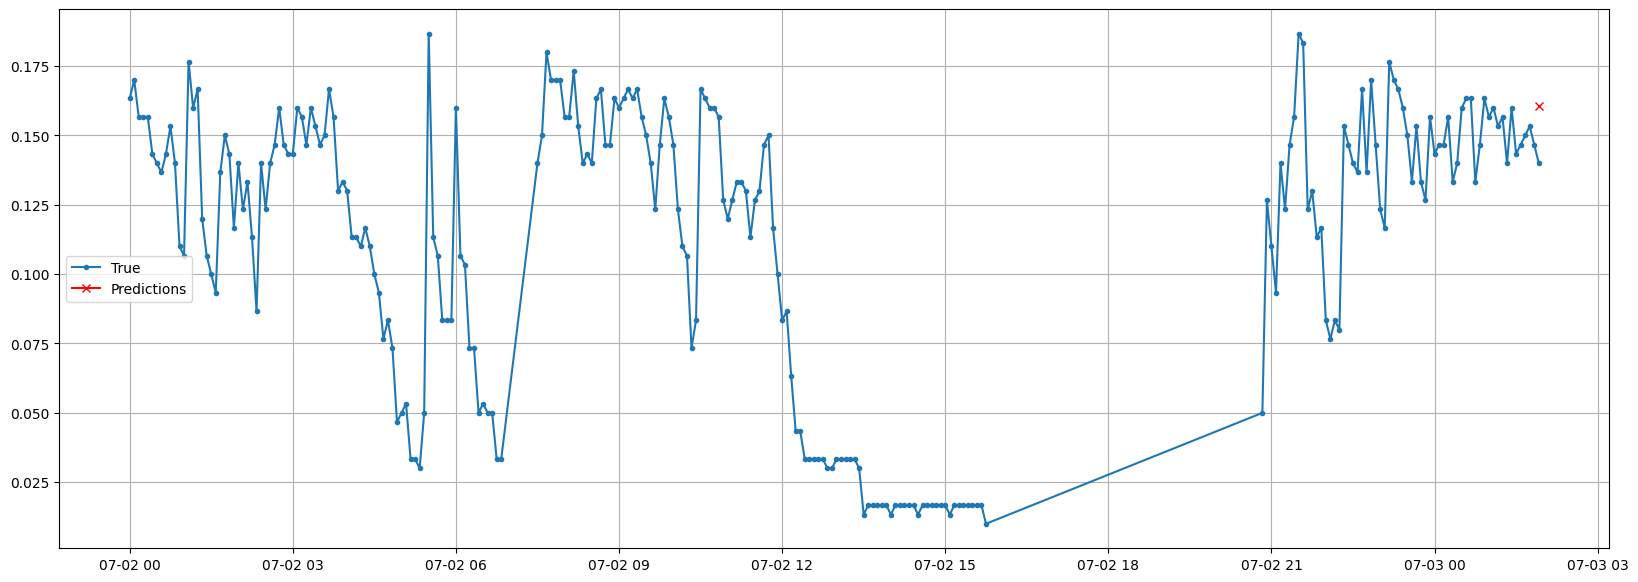

In [32]:
Y_pred = mulvar_model.predict(test_mulvar_ds1)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test1.index[-1], end=test1.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [33]:
fit_and_evaluate(mulvar_model, train_mulvar_ds2, valid_mulvar_ds2)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 5.2321e-04 - mae: 0.0164 - val_loss: 1.6375e-04 - val_mae: 0.0111
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.8158e-04 - mae: 0.0107 - val_loss: 1.0992e-04 - val_mae: 0.0096
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2.5032e-04 - mae: 0.0100 - val_loss: 8.9771e-05 - val_mae: 0.0086
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.2792e-04 - mae: 0.0095 - val_loss: 6.6576e-05 - val_mae: 0.0076
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.2023e-04 - mae: 0.0091 - val_loss: 5.7472e-05 - val_mae: 0.0071
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.1350e-04 - mae: 0.0088 - val_loss: 4.6021e-05 - val_mae: 0.0065
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.0440e-04 - mae: 0.0085 - val_loss: 4.1984e-05 - val_mae: 0.0061
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 1.9932e-04 - mae: 0.0085 - val_loss: 3.6976e-05 - val_m

5385.636817663908

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


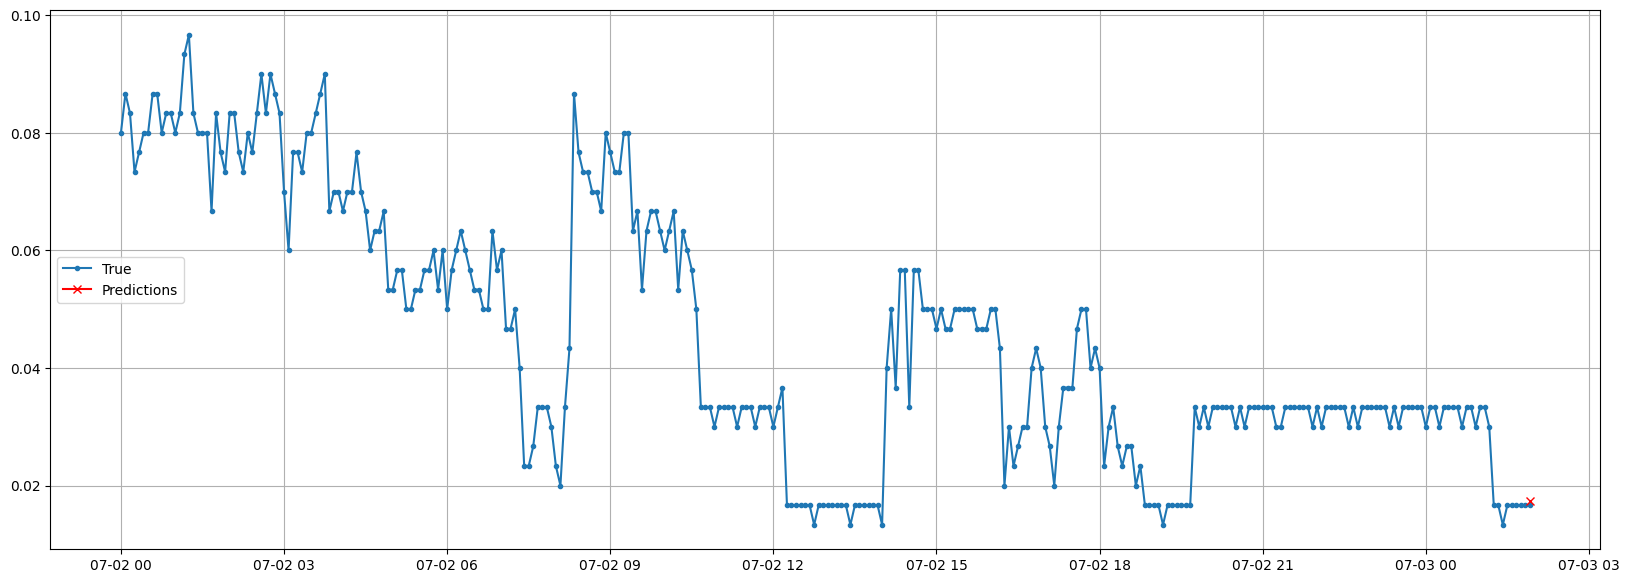

In [34]:
Y_pred = mulvar_model.predict(test_mulvar_ds2)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test2.index[-1], end=test2.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


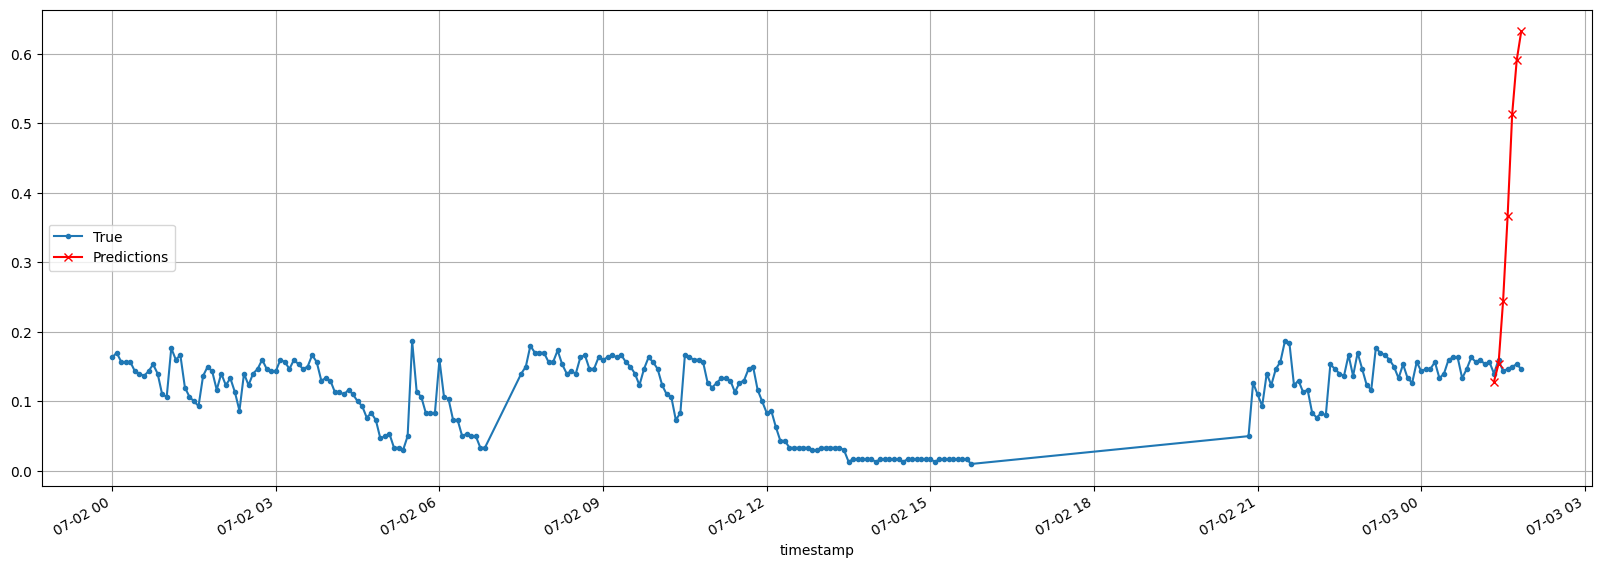

In [35]:
X = ts1[:-sequence_lenght].to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


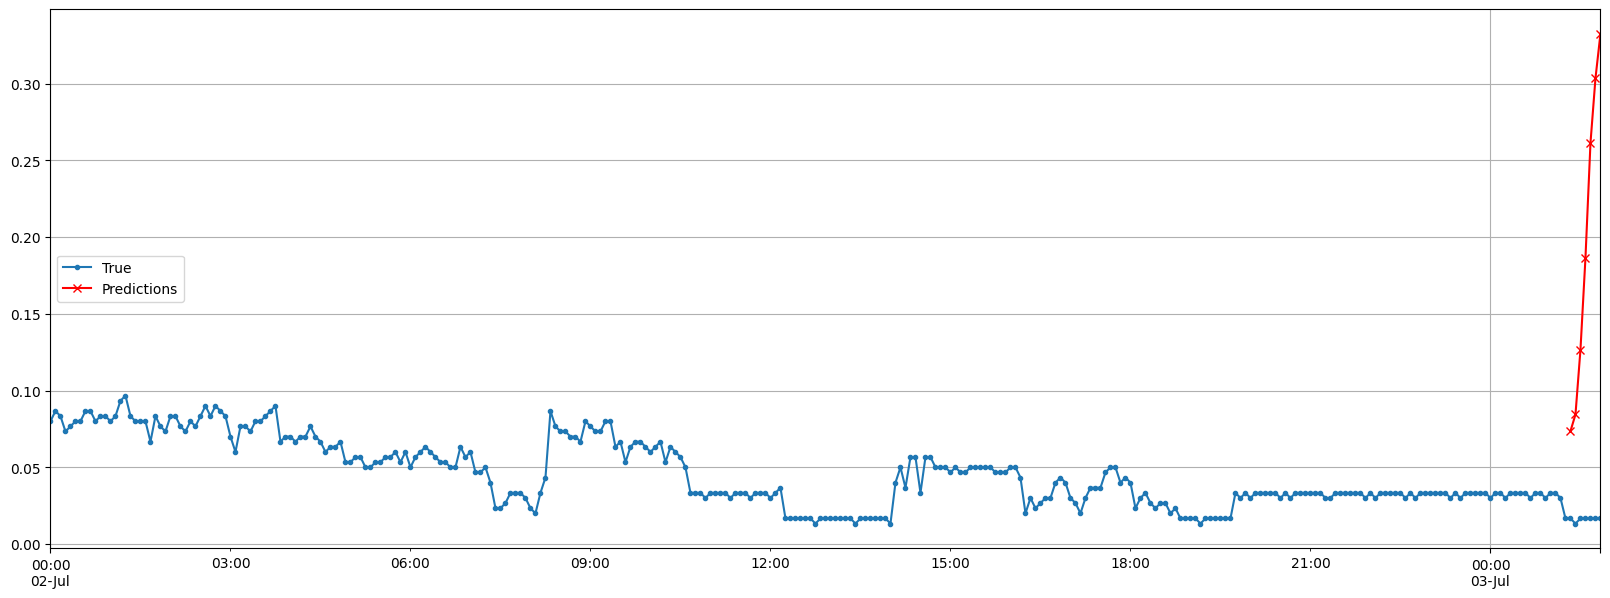

In [36]:
X = ts2[:-sequence_lenght].to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [37]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

In [38]:
# ENDPOINT 1:

ahead_train_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    train1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    valid1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    test1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

In [39]:
# ENDPOINT 2:

ahead_train_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    train2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    valid2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    test2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [40]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
fit_and_evaluate(ahead_model, ahead_train_ds1, ahead_valid_ds1)

Epoch 1/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3133 - mae: 0.6307 - val_loss: 0.1899 - val_mae: 0.4467
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2922 - mae: 0.6006 - val_loss: 0.1913 - val_mae: 0.4605
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2913 - mae: 0.6000 - val_loss: 0.1901 - val_mae: 0.4531
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2900 - mae: 0.5981 - val_loss: 0.1889 - val_mae: 0.4469
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2897 - mae: 0.5979 - val_loss: 0.1892 - val_mae: 0.4563
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2893 - mae: 0.5974 - val_loss: 0.1874 - val_mae: 0.4495
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2893 - mae: 0.5974 - val_loss: 0.1876 - val_mae: 0.4477
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2888 - mae: 0.5962 - val_loss: 0.1890 - val_mae: 0.4443
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - lo

444322.6158618927

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


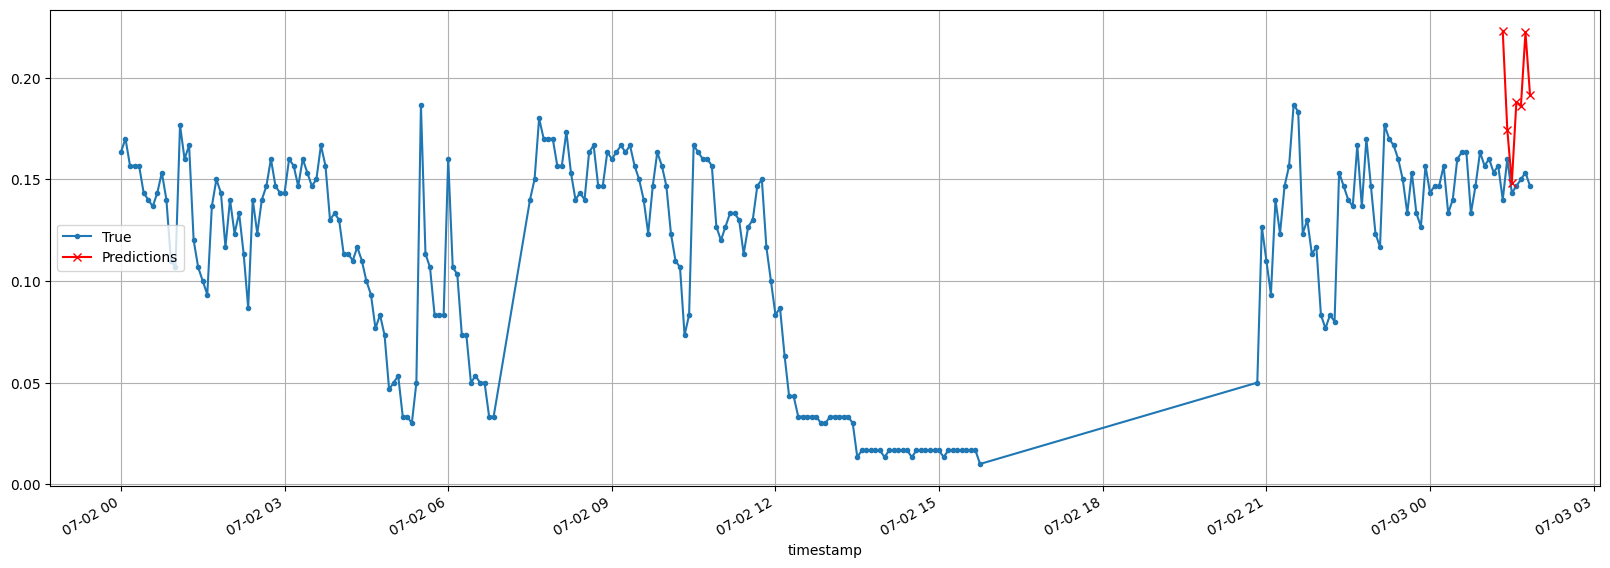

In [42]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [43]:
fit_and_evaluate(ahead_model, ahead_train_ds2, ahead_valid_ds2)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1911 - mae: 0.3294 - val_loss: 0.0290 - val_mae: 0.1334
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1357 - mae: 0.2710 - val_loss: 0.0245 - val_mae: 0.0932
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1332 - mae: 0.2670 - val_loss: 0.0245 - val_mae: 0.0910
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1311 - mae: 0.2650 - val_loss: 0.0243 - val_mae: 0.0832
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1334 - mae: 0.2686 - val_loss: 0.0242 - val_mae: 0.0935
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1442 - mae: 0.2796 - val_loss: 0.0284 - val_mae: 0.1143
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1299 - mae: 0.2635 - val_loss: 0.0273 - val_mae: 0.1007
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1316 - mae: 0.2675 - val_loss: 0.0241 - val_mae: 0.0861
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - lo

81832.20773935318

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


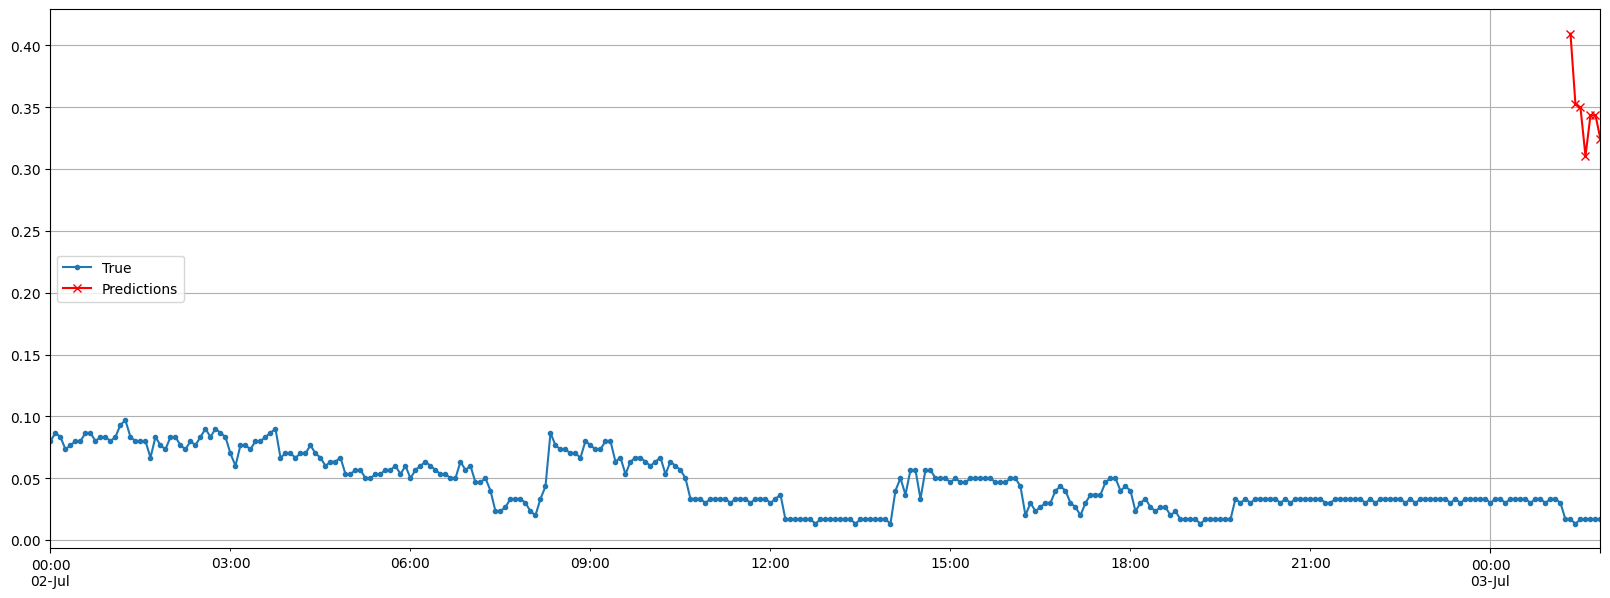

In [44]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [45]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [46]:
seq2seq_train1 = to_seq2seq_dataset(train1, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid1 = to_seq2seq_dataset(valid1, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test1 = to_seq2seq_dataset(test1, seq_length=sequence_lenght, ahead=prediction_lenght)

seq2seq_train2 = to_seq2seq_dataset(train2, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid2 = to_seq2seq_dataset(valid2, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test2 = to_seq2seq_dataset(test2, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

It is almost identical to our previous model: the only difference is that we set
return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 'batch_size'), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 'batch_size'-dimensional
vector as input and outputting a 'prediction_lenght'-dimensional vector.

In [47]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
fit_and_evaluate(seq2seq_model, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    701/Unknown 9s 11ms/step - loss: 0.3657 - mae: 0.7021

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.3655 - mae: 0.7018 - val_loss: 0.1882 - val_mae: 0.4428
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.3424 - mae: 0.6684 - val_loss: 0.1870 - val_mae: 0.4402
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.3418 - mae: 0.6676 - val_loss: 0.1865 - val_mae: 0.4395
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.3415 - mae: 0.6669 - val_loss: 0.1865 - val_mae: 0.4403
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.3397 - mae: 0.6649 - val_loss: 0.1865 - val_mae: 0.4411
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3390 - mae: 0.6642 - val_loss: 0.1864 - val_mae: 0.4398
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3390 - mae: 0.6642 - val_loss: 0.1864 - val_mae: 0.4399
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3391 - mae: 0.6640 - val_loss: 0.1862 - val_mae: 0.4383
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss

438347.0416069031

In [49]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test1)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test1.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test1["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE for +1: 382,352
MAE for +2: 337,185
MAE for +3: 373,885
MAE for +4: 337,248
MAE for +5: 370,844
MAE for +6: 378,423
MAE for +7: 324,030


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


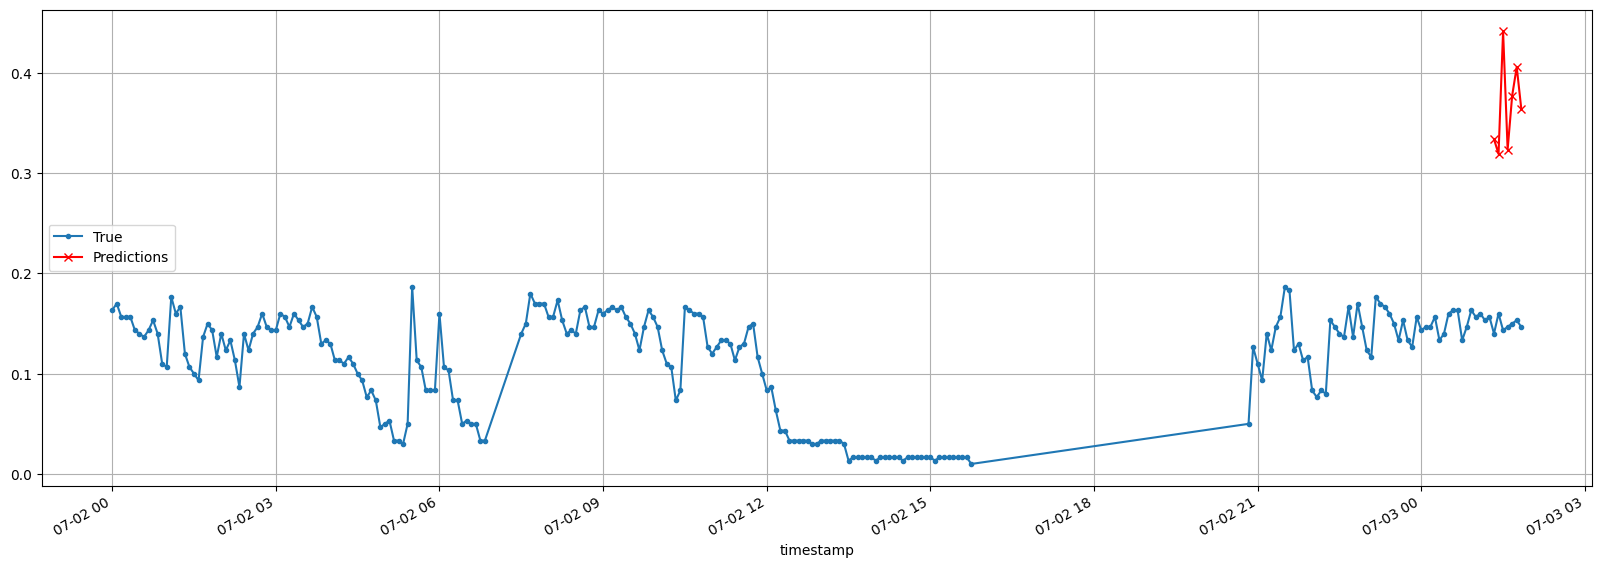

In [50]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [51]:
fit_and_evaluate(seq2seq_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    581/Unknown 8s 10ms/step - loss: 0.1678 - mae: 0.3073

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.1683 - mae: 0.3079 - val_loss: 0.0422 - val_mae: 0.1512
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1547 - mae: 0.2956 - val_loss: 0.0553 - val_mae: 0.1812
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1500 - mae: 0.2911 - val_loss: 0.0568 - val_mae: 0.1765
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.1473 - mae: 0.2858 - val_loss: 0.0607 - val_mae: 0.1788
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.1462 - mae: 0.2833 - val_loss: 0.0536 - val_mae: 0.1601
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.1466 - mae: 0.2821 - val_loss: 0.0615 - val_mae: 0.1701
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.1485 - mae: 0.2837 - val_loss: 0.0407 - val_mae: 0.1229
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.1434 - mae: 0.2753 - val_loss: 0.0447 - val_mae: 0.1314
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - l

110654.50310707092

In [52]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test2)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test2.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test2["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE for +1: 251,741
MAE for +2: 253,663
MAE for +3: 242,496
MAE for +4: 244,730
MAE for +5: 245,569
MAE for +6: 240,594
MAE for +7: 234,309


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


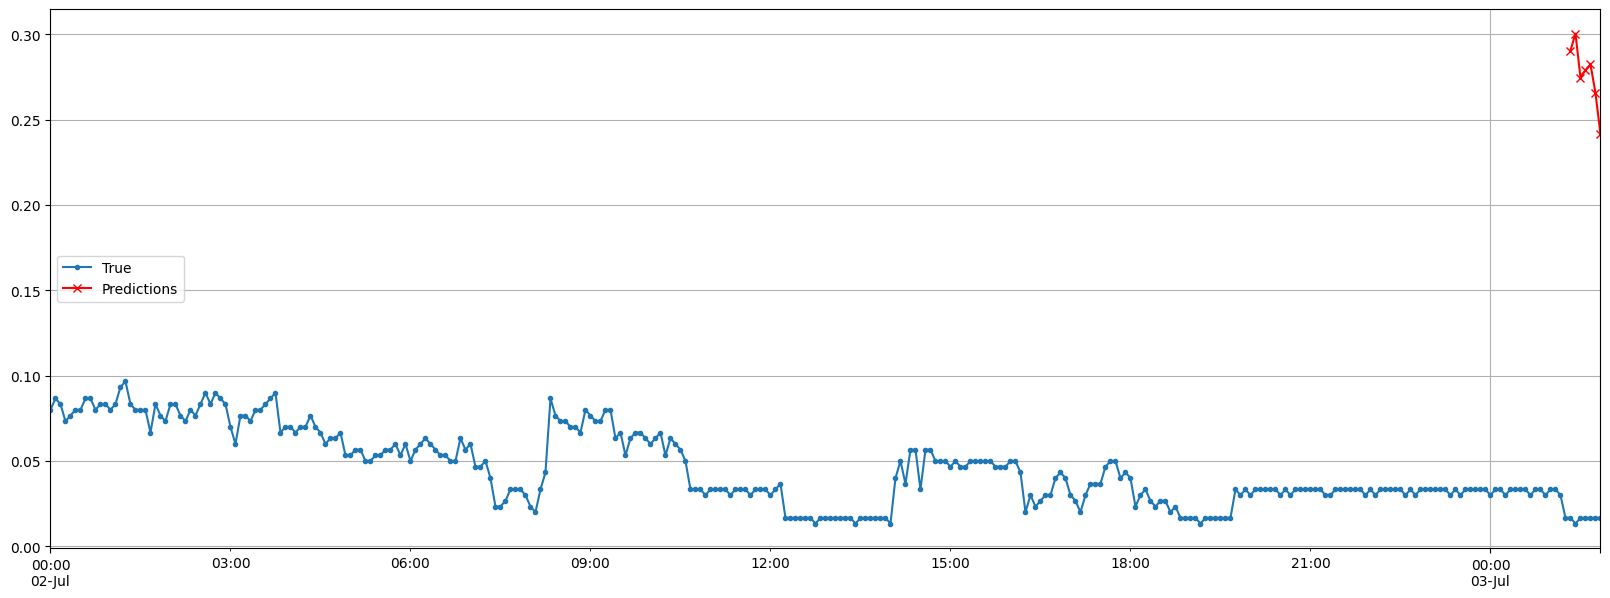

In [53]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### RNN with layer normalization

In [54]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [55]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(neurons), return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [56]:
fit_and_evaluate(custom_ln_model, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    697/Unknown 11s 13ms/step - loss: 0.3849 - mae: 0.7256

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.3842 - mae: 0.7248 - val_loss: 0.1911 - val_mae: 0.4472
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.3462 - mae: 0.6707 - val_loss: 0.1881 - val_mae: 0.4427
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.3426 - mae: 0.6664 - val_loss: 0.1869 - val_mae: 0.4411
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3416 - mae: 0.6663 - val_loss: 0.1861 - val_mae: 0.4406
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3406 - mae: 0.6659 - val_loss: 0.1857 - val_mae: 0.4411
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3393 - mae: 0.6643 - val_loss: 0.1854 - val_mae: 0.4417
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3400 - mae: 0.6656 - val_loss: 0.1851 - val_mae: 0.4404
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.3384 - mae: 0.6631 - val_loss: 0.1849 - val_mae: 0.4398
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - 

439813.2264614105

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


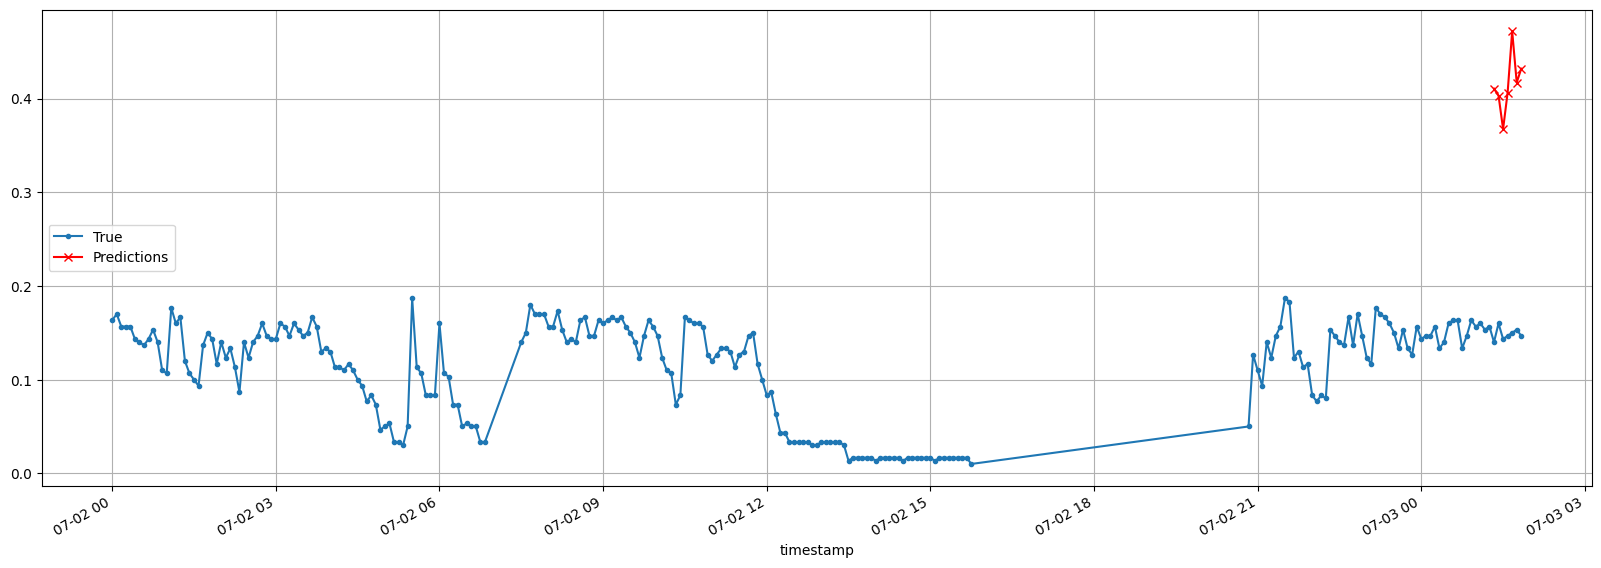

In [57]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [58]:
fit_and_evaluate(custom_ln_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    588/Unknown 8s 11ms/step - loss: 0.1673 - mae: 0.3074

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.1675 - mae: 0.3076 - val_loss: 0.0382 - val_mae: 0.1281
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.1533 - mae: 0.2885 - val_loss: 0.0369 - val_mae: 0.1190
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1420 - mae: 0.2739 - val_loss: 0.0343 - val_mae: 0.1162
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.1401 - mae: 0.2709 - val_loss: 0.0336 - val_mae: 0.1081
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.1403 - mae: 0.2700 - val_loss: 0.0304 - val_mae: 0.0969
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.1391 - mae: 0.2675 - val_loss: 0.0283 - val_mae: 0.0857
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1386 - mae: 0.2671 - val_loss: 0.0265 - val_mae: 0.0773
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1385 - mae: 0.2678 - val_loss: 0.0258 - val_mae: 0.0750
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step -

72529.68102693558

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


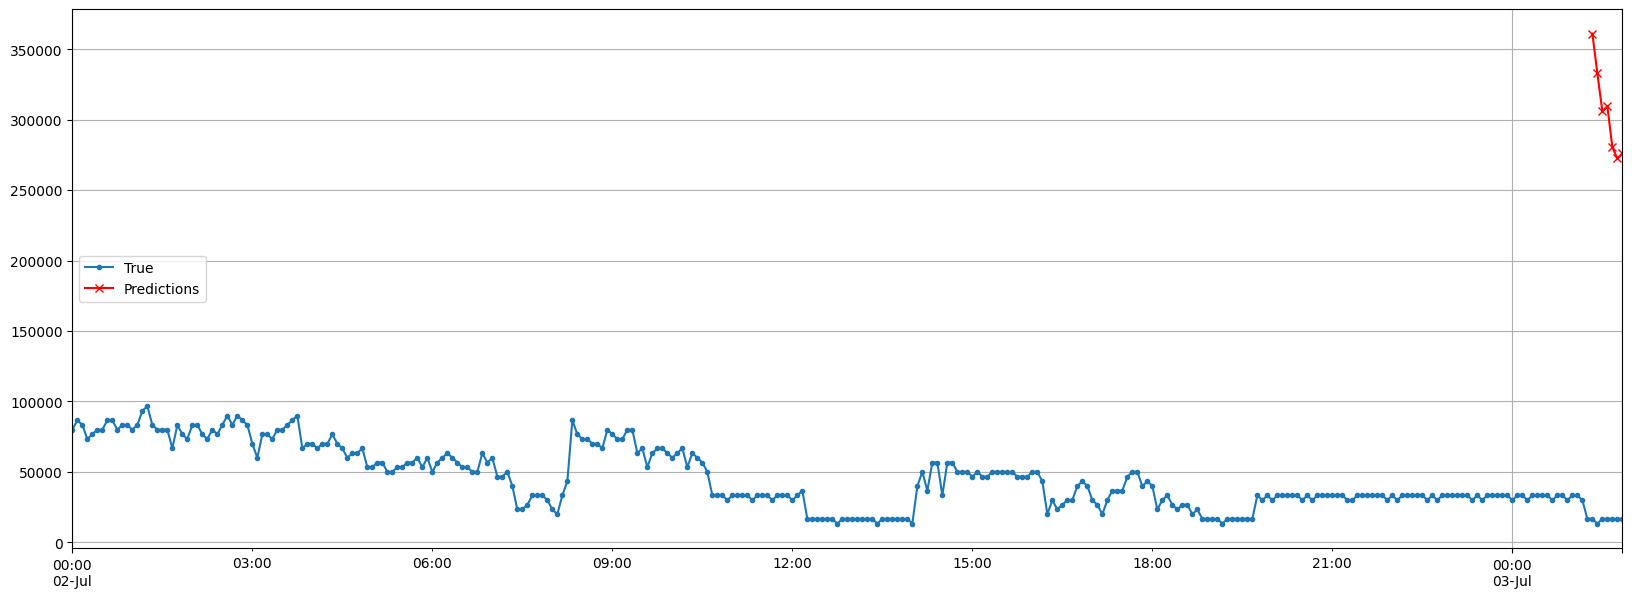

In [59]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2 * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 #### LSTM

In [60]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
fit_and_evaluate(lstm, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    694/Unknown 17s 19ms/step - loss: 0.3573 - mae: 0.7114

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.3566 - mae: 0.7103 - val_loss: 0.1887 - val_mae: 0.4410
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3438 - mae: 0.6722 - val_loss: 0.1883 - val_mae: 0.4393
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.3433 - mae: 0.6713 - val_loss: 0.1882 - val_mae: 0.4390
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3422 - mae: 0.6700 - val_loss: 0.1880 - val_mae: 0.4372
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.3420 - mae: 0.6696 - val_loss: 0.1880 - val_mae: 0.4373
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.3428 - mae: 0.6705 - val_loss: 0.1879 - val_mae: 0.4371
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.3416 - mae: 0.6690 - val_loss: 0.1877 - val_mae: 0.4364
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3420 - mae: 0.6691 - val_loss: 0.1877 - val_mae: 0.4362
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step

436171.38266563416

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


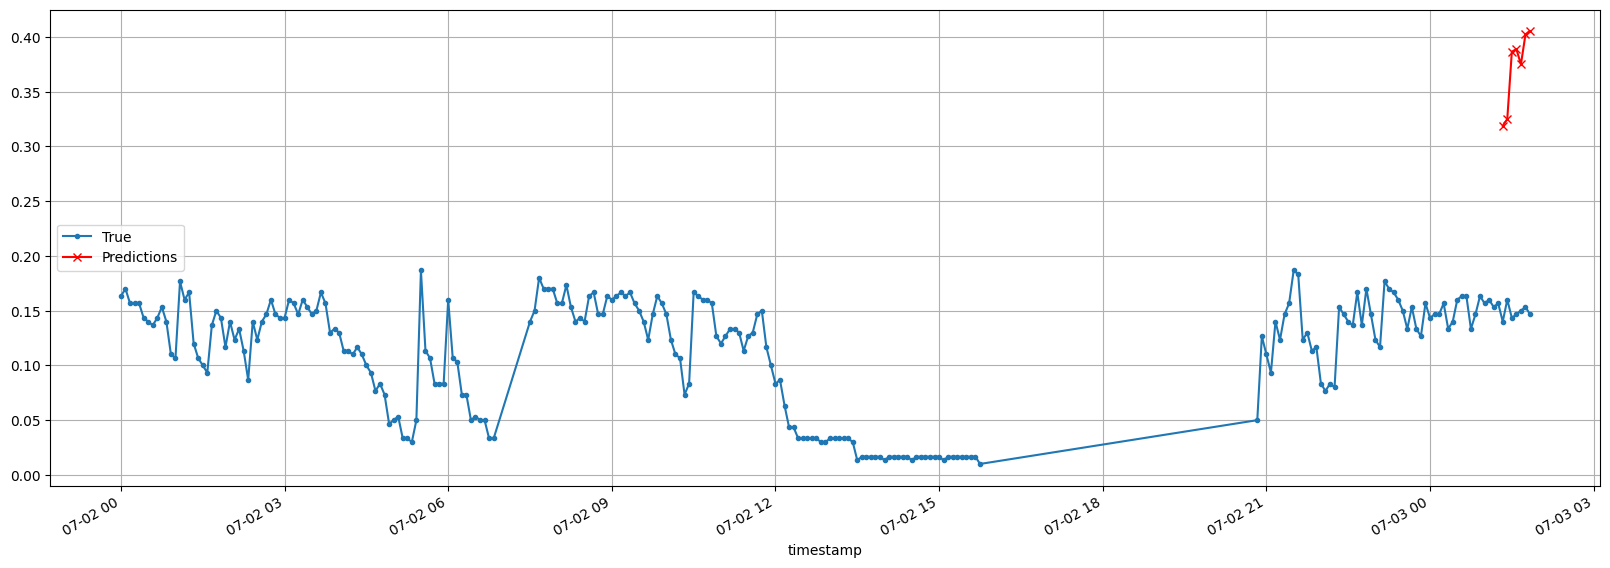

In [62]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [63]:
fit_and_evaluate(lstm, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    588/Unknown 9s 12ms/step - loss: 0.1630 - mae: 0.2984

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.1632 - mae: 0.2987 - val_loss: 0.0319 - val_mae: 0.1283
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.1518 - mae: 0.2893 - val_loss: 0.0384 - val_mae: 0.1566
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.1490 - mae: 0.2848 - val_loss: 0.0400 - val_mae: 0.1580
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.1482 - mae: 0.2817 - val_loss: 0.0430 - val_mae: 0.1677
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.1476 - mae: 0.2793 - val_loss: 0.0370 - val_mae: 0.1392
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.1428 - mae: 0.2736 - val_loss: 0.0344 - val_mae: 0.1242
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.1438 - mae: 0.2743 - val_loss: 0.0308 - val_mae: 0.1066
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1419 - mae: 0.2725 - val_loss: 0.0306 - val_mae: 0.1046
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - 

100266.50130748749

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


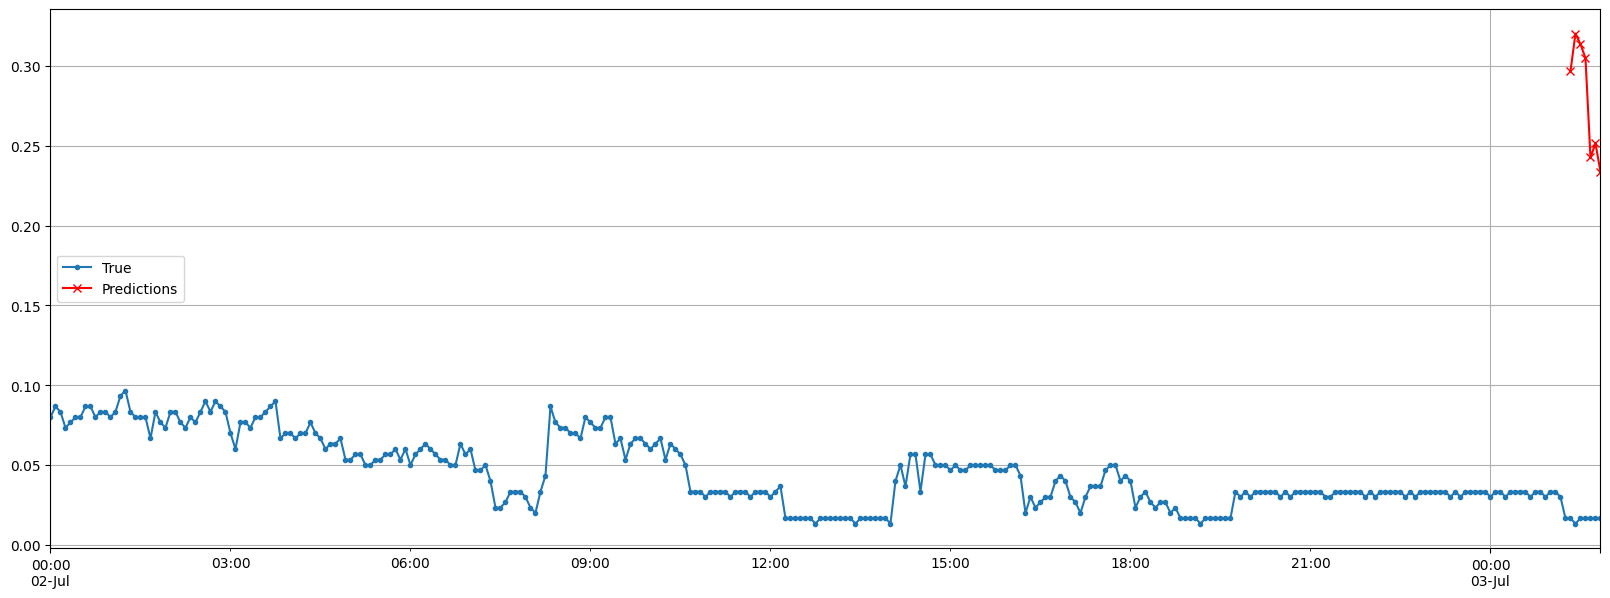

In [64]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### GRU

The GRU cell is a simplified version of the LSTM cell...

In [65]:
gru = tf.keras.Sequential([
  tf.keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
fit_and_evaluate(gru, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    701/Unknown 10s 12ms/step - loss: 0.3591 - mae: 0.7064

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.3588 - mae: 0.7061 - val_loss: 0.1858 - val_mae: 0.4382
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3438 - mae: 0.6730 - val_loss: 0.1859 - val_mae: 0.4369
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.3422 - mae: 0.6704 - val_loss: 0.1859 - val_mae: 0.4349
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.3414 - mae: 0.6691 - val_loss: 0.1858 - val_mae: 0.4349
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.3413 - mae: 0.6688 - val_loss: 0.1858 - val_mae: 0.4354
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3407 - mae: 0.6679 - val_loss: 0.1857 - val_mae: 0.4344
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.3404 - mae: 0.6673 - val_loss: 0.1857 - val_mae: 0.4338
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.3404 - mae: 0.6671 - val_loss: 0.1856 - val_mae: 0.4343
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/ste

433558.1660270691

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


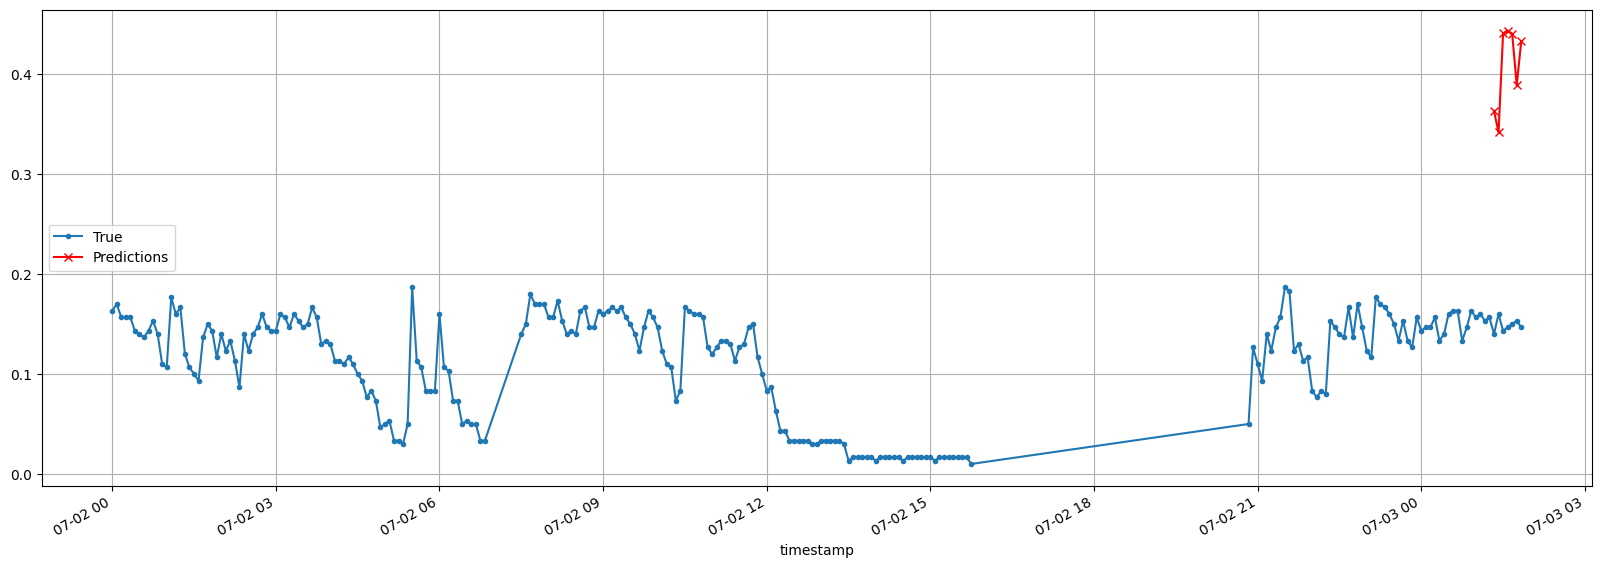

In [67]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [68]:
fit_and_evaluate(gru, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    586/Unknown 10s 12ms/step - loss: 0.1664 - mae: 0.3013

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.1667 - mae: 0.3017 - val_loss: 0.0360 - val_mae: 0.1392
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.1535 - mae: 0.2900 - val_loss: 0.0410 - val_mae: 0.1599
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.1533 - mae: 0.2890 - val_loss: 0.0421 - val_mae: 0.1619
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1510 - mae: 0.2851 - val_loss: 0.0404 - val_mae: 0.1550
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.1496 - mae: 0.2824 - val_loss: 0.0397 - val_mae: 0.1514
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.1497 - mae: 0.2816 - val_loss: 0.0370 - val_mae: 0.1388
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1491 - mae: 0.2799 - val_loss: 0.0349 - val_mae: 0.1289
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1473 - mae: 0.2772 - val_loss: 0.0328 - val_mae: 0.1178
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - 

98588.59330415726

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


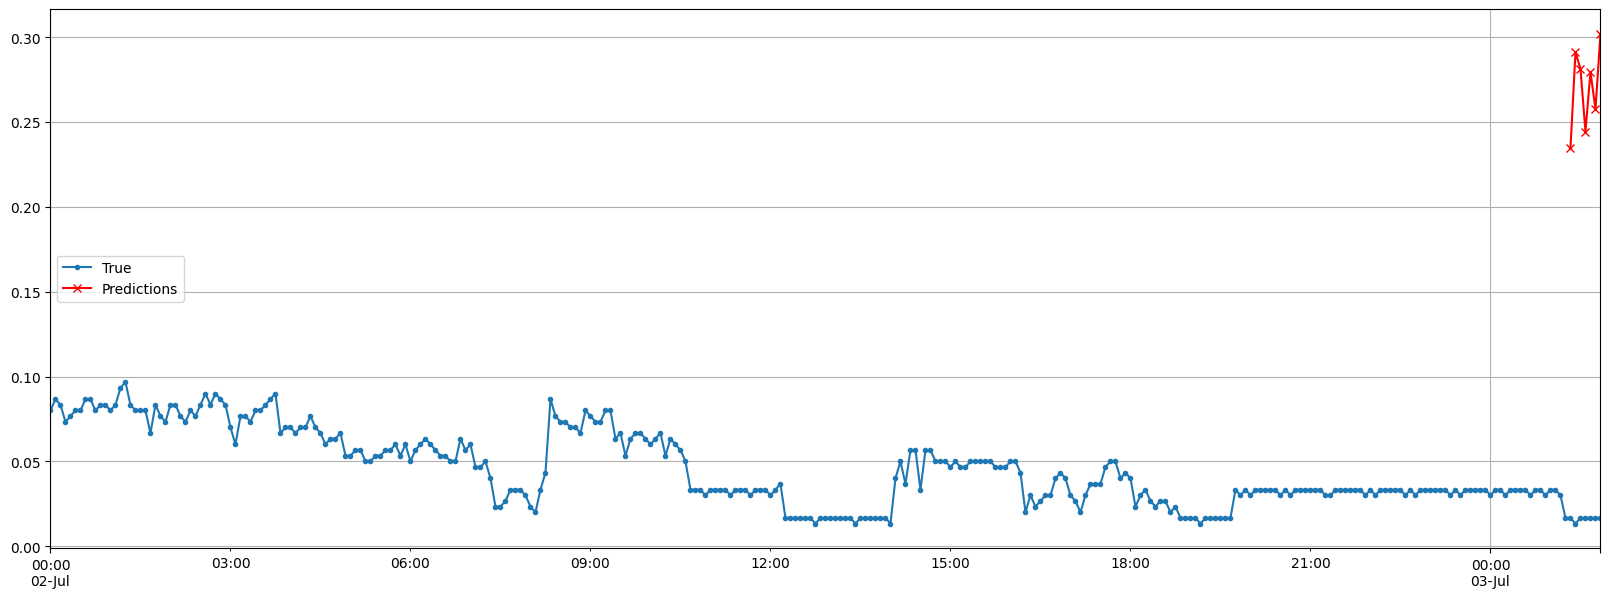

In [69]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### CNN

In [70]:
seq2seq_cnn_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Conv1D(prediction_lenght, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [71]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    695/Unknown 9s 11ms/step - loss: 0.3608 - mae: 0.6962

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.3600 - mae: 0.6953 - val_loss: 0.1870 - val_mae: 0.4396
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.3419 - mae: 0.6678 - val_loss: 0.1862 - val_mae: 0.4355
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.3417 - mae: 0.6668 - val_loss: 0.1858 - val_mae: 0.4350
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.3395 - mae: 0.6643 - val_loss: 0.1856 - val_mae: 0.4346
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.3403 - mae: 0.6653 - val_loss: 0.1853 - val_mae: 0.4330
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.3405 - mae: 0.6654 - val_loss: 0.1851 - val_mae: 0.4350
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.3395 - mae: 0.6640 - val_loss: 0.1851 - val_mae: 0.4350
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.3386 - mae: 0.6625 - val_loss: 0.1848 - val_mae: 0.4346
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - lo

431372.91073799133

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


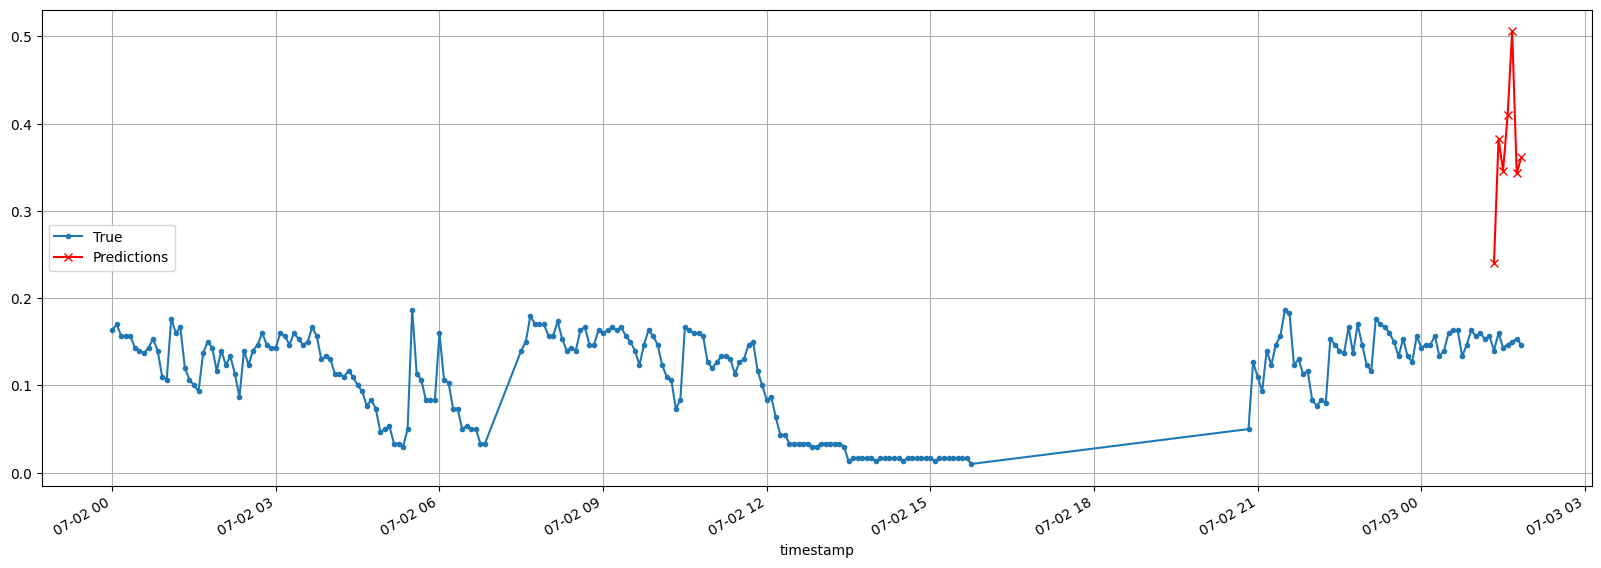

In [72]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [73]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    579/Unknown 8s 11ms/step - loss: 0.1633 - mae: 0.2997

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.1637 - mae: 0.3003 - val_loss: 0.0410 - val_mae: 0.1442
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1529 - mae: 0.2919 - val_loss: 0.0431 - val_mae: 0.1526
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1500 - mae: 0.2893 - val_loss: 0.0441 - val_mae: 0.1577
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.1464 - mae: 0.2857 - val_loss: 0.0411 - val_mae: 0.1428
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1414 - mae: 0.2784 - val_loss: 0.0355 - val_mae: 0.1226
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.1392 - mae: 0.2728 - val_loss: 0.0327 - val_mae: 0.1135
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1390 - mae: 0.2737 - val_loss: 0.0309 - val_mae: 0.1094
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.1374 - mae: 0.2697 - val_loss: 0.0302 - val_mae: 0.1079
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - lo

105420.5670952797

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


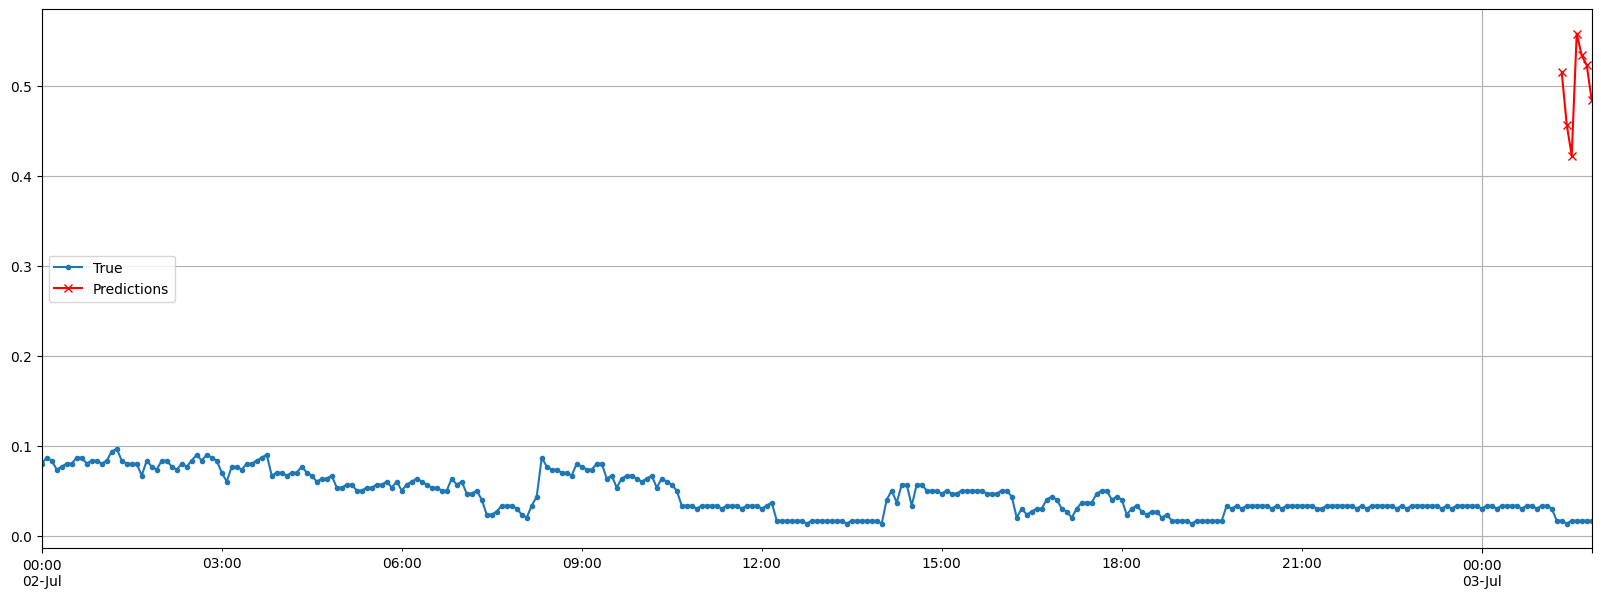

In [74]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

LSTM and GRU cells are one of the main reasons behind the success of RNNs.
Yet while they can tackle much longer sequences than simple RNNs, they still
have a fairly limited short-term memory, and they have a hard time learning
long-term patterns in sequences of 100 time steps or more, such as audio
samples, long time series, or long sentences. One way to solve this is to shorten
the input sequences; for example, using 1D convolutional layers.

In [75]:
stride = 2
k_size = 4

conv_rnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=k_size, strides=stride, activation="relu", input_shape=[None, num_features]),
  tf.keras.layers.GRU(batch_size, return_sequences=True),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [76]:
# ENDPOINT 1:
longer_train1 = to_seq2seq_dataset(train1, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid1 = to_seq2seq_dataset(valid1, seq_length=sequence_lenght*2)
longer_test1 = to_seq2seq_dataset(test1, seq_length=sequence_lenght*2)
downsampled_train1 = longer_train1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid1 = longer_valid1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test1 = longer_test1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [77]:
fit_and_evaluate(conv_rnn_model, downsampled_train1, downsampled_valid1)

Epoch 1/10
    695/Unknown 12s 14ms/step - loss: 0.3442 - mae: 0.6785

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.3436 - mae: 0.6776 - val_loss: 0.1829 - val_mae: 0.4229
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.3343 - mae: 0.6586 - val_loss: 0.1818 - val_mae: 0.4200
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.3324 - mae: 0.6560 - val_loss: 0.1811 - val_mae: 0.4198
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.3317 - mae: 0.6546 - val_loss: 0.1807 - val_mae: 0.4178
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.3309 - mae: 0.6534 - val_loss: 0.1804 - val_mae: 0.4164
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.3299 - mae: 0.6521 - val_loss: 0.1802 - val_mae: 0.4168
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.3296 - mae: 0.6517 - val_loss: 0.1801 - val_mae: 0.4152
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3288 - mae: 0.6504 - val_loss: 0.1800 - val_mae: 0.4151
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/ste

412649.7805118561

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


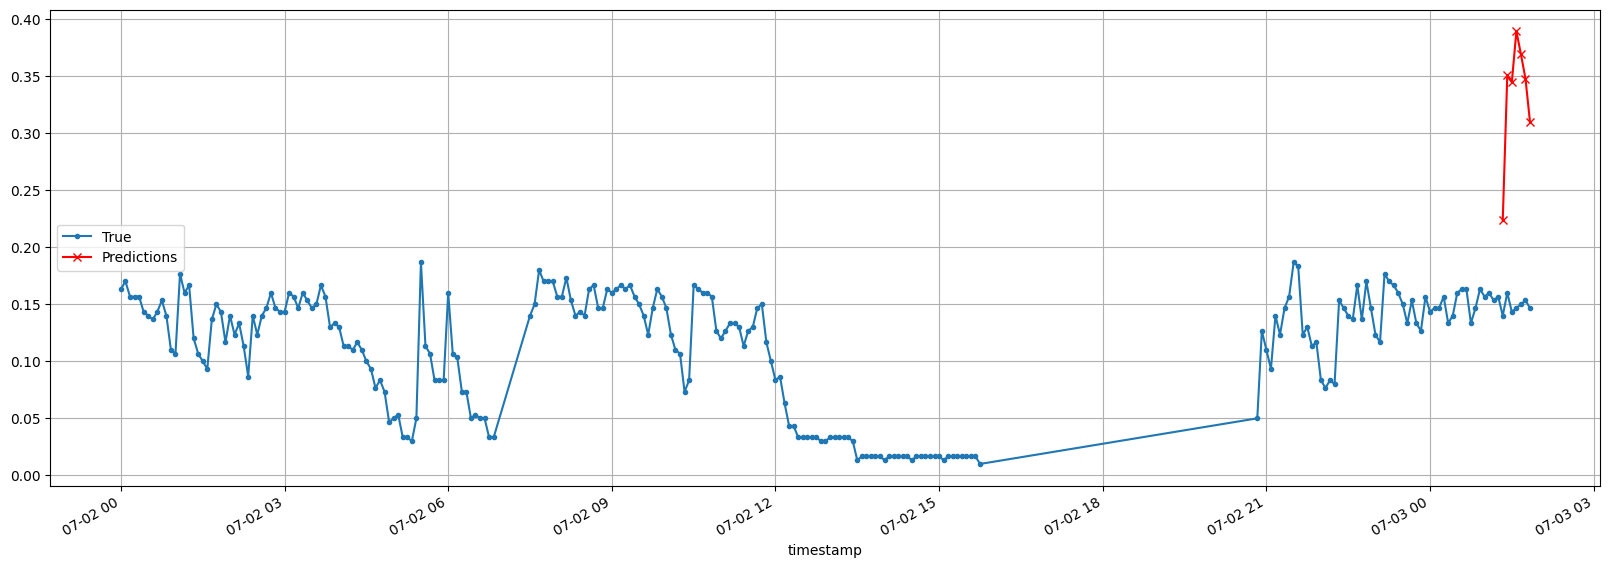

In [78]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [79]:
# ENDPOINT 2:
longer_train2 = to_seq2seq_dataset(train2, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid2 = to_seq2seq_dataset(valid2, seq_length=sequence_lenght*2)
longer_test2 = to_seq2seq_dataset(test2, seq_length=sequence_lenght*2)
downsampled_train2 = longer_train2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid2 = longer_valid2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test2 = longer_test2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [80]:
fit_and_evaluate(conv_rnn_model, downsampled_train2, downsampled_valid2)

Epoch 1/10
    588/Unknown 11s 15ms/step - loss: 0.1476 - mae: 0.2841

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.1477 - mae: 0.2842 - val_loss: 0.0460 - val_mae: 0.1533
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.1402 - mae: 0.2806 - val_loss: 0.0551 - val_mae: 0.1689
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.1401 - mae: 0.2770 - val_loss: 0.0603 - val_mae: 0.1721
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.1379 - mae: 0.2734 - val_loss: 0.0429 - val_mae: 0.1356
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.1363 - mae: 0.2696 - val_loss: 0.0396 - val_mae: 0.1250
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.1380 - mae: 0.2701 - val_loss: 0.0377 - val_mae: 0.1203
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1353 - mae: 0.2665 - val_loss: 0.0381 - val_mae: 0.1193
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1353 - mae: 0.2662 - val_loss: 0.0368 - val_mae: 0.1162
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step 

116231.92578554153

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


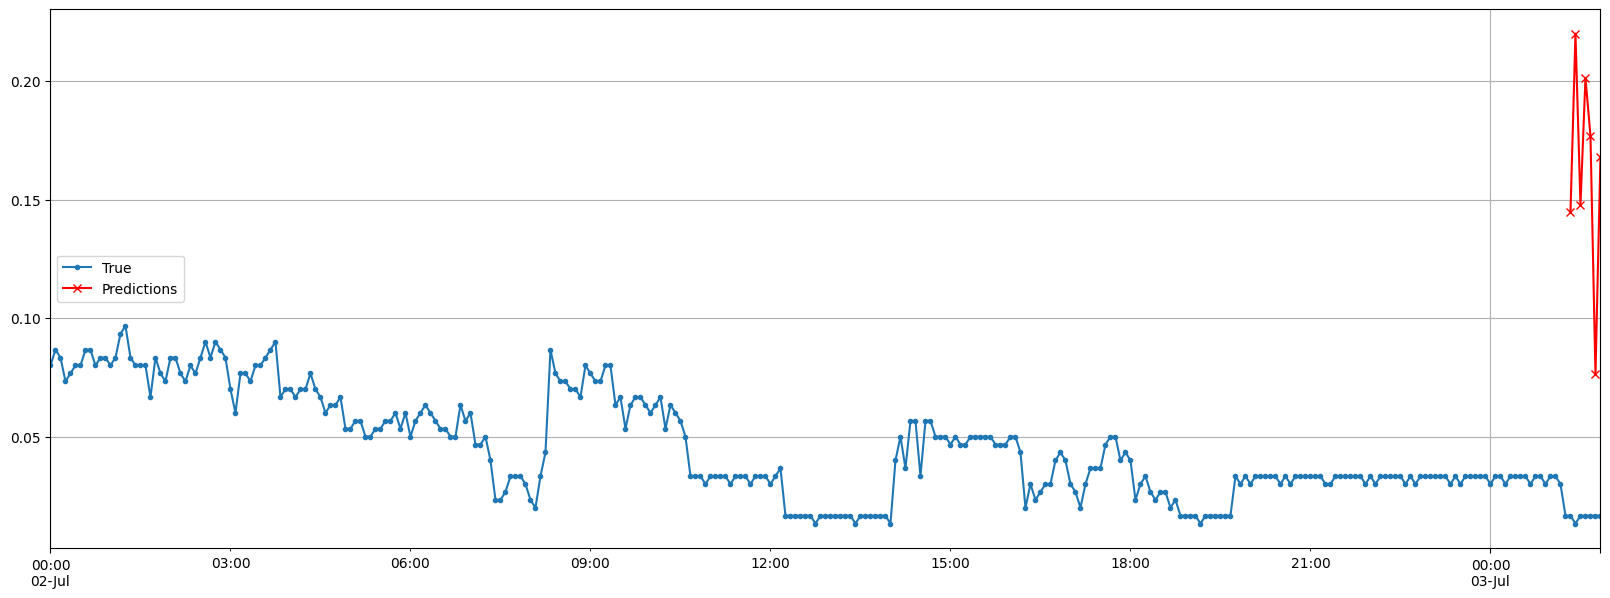

In [81]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

## ARMA family



In [82]:
from statsmodels.tsa.arima.model import ARIMA

Check for stationarity with the Augmented Dickey-Fuller test

In [83]:
from statsmodels.tsa.stattools import adfuller

print("Endpoint 1:")
result1 = adfuller(train1['avg_invocations_rate'])
print('ADF Statistic:', result1[0])
print('p-value:', result1[1])
print("Endpoint 2:")
result2 = adfuller(train2['avg_invocations_rate'])
print('ADF Statistic:', result2[0])
print('p-value:', result2[1])

Endpoint 1:
ADF Statistic: -12.170960005983266
p-value: 1.4211817431425884e-22
Endpoint 2:
ADF Statistic: -9.579642062045842
p-value: 2.175838371317368e-16


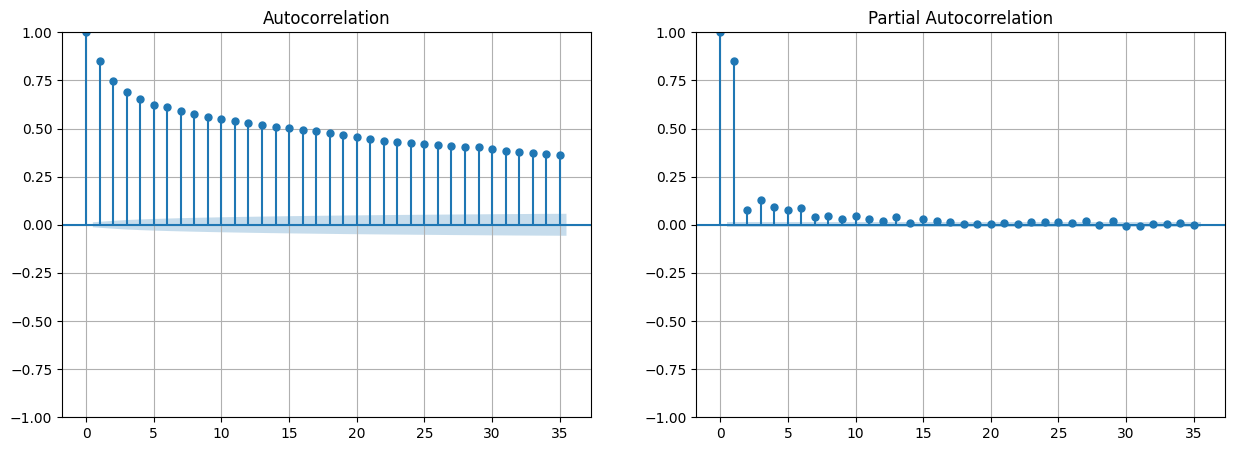

In [84]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train1['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train1['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

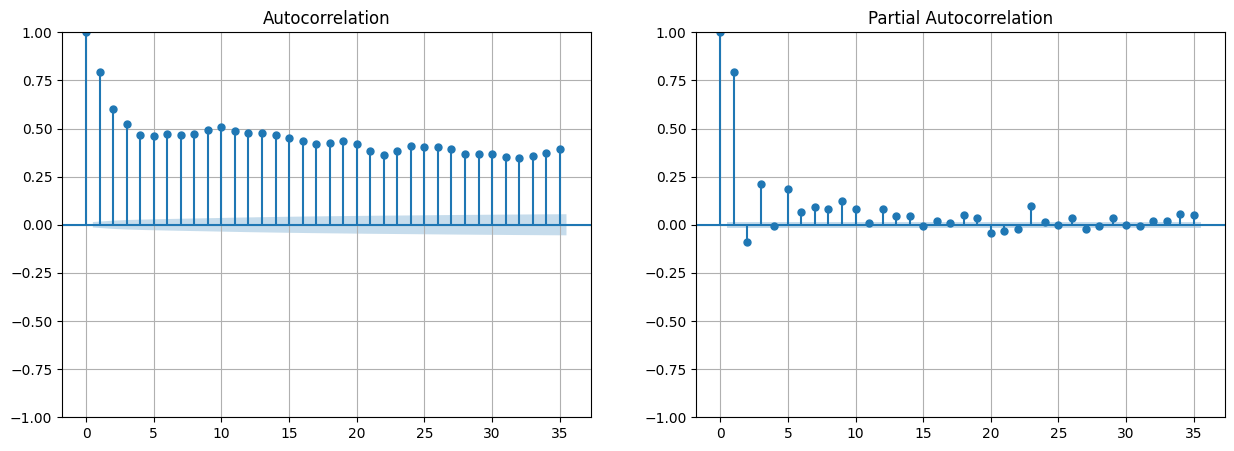

In [85]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train2['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train2['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

order=(p, d, q):
* p = the past p values of the time series, "how far back into the past the model should look";
* d = *order of integration*, running d consecutive rounds of differencing computes an approximation of the dth order derivative of the time series, so it will eliminate polynomial trends up to degree d.
* q = the past q forecast errors ε(t);

seasonal_order=(P, D, Q, s)
* P = , D = , Q =  : to model the time series at  (t–s), (t–2s), (t–3s);
* s = the period of the seasonal pattern.


In [86]:
trimmed_valid1 = ts1.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid1, order=(1,1,1))
arima = arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


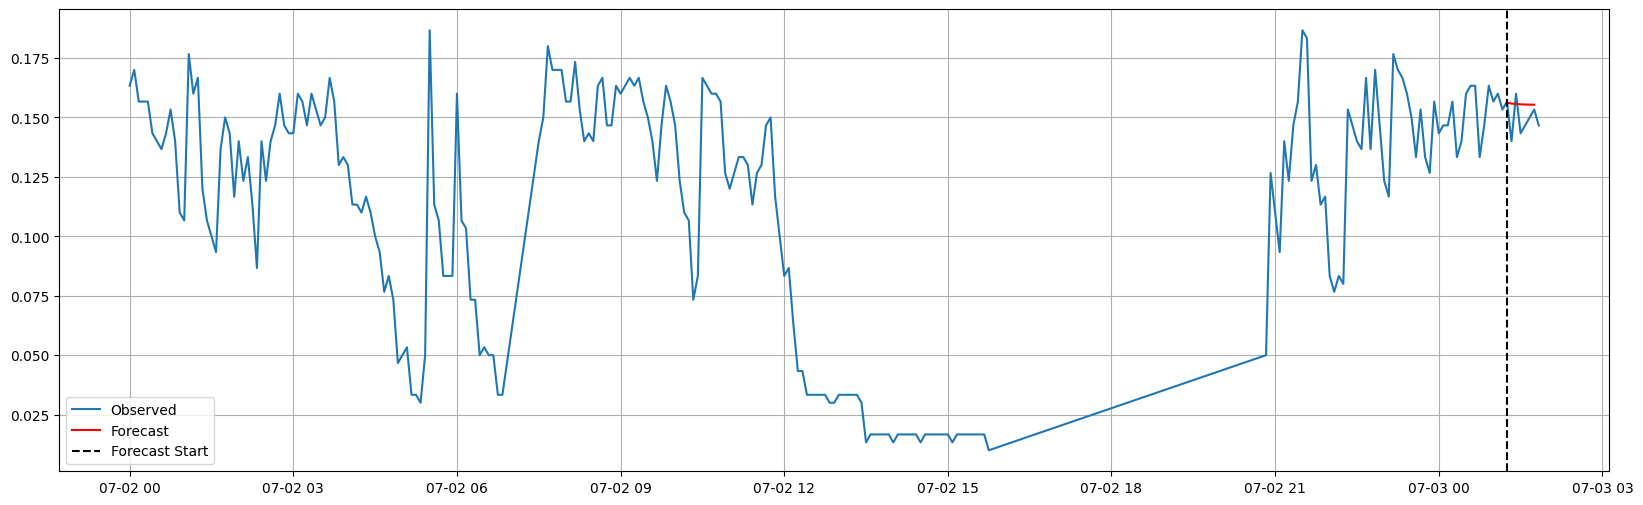

In [87]:
# Forecasting
forecast1 = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts1.index, ts1, label='Observed')
plt.plot(pd.date_range(trimmed_valid1.index[-1], periods=prediction_lenght, freq=freq), forecast1, label='Forecast', color='red')
plt.axvline(trimmed_valid1.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [88]:
trimmed_valid2 = ts2.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid2, order=(1,1,1))
arima = arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


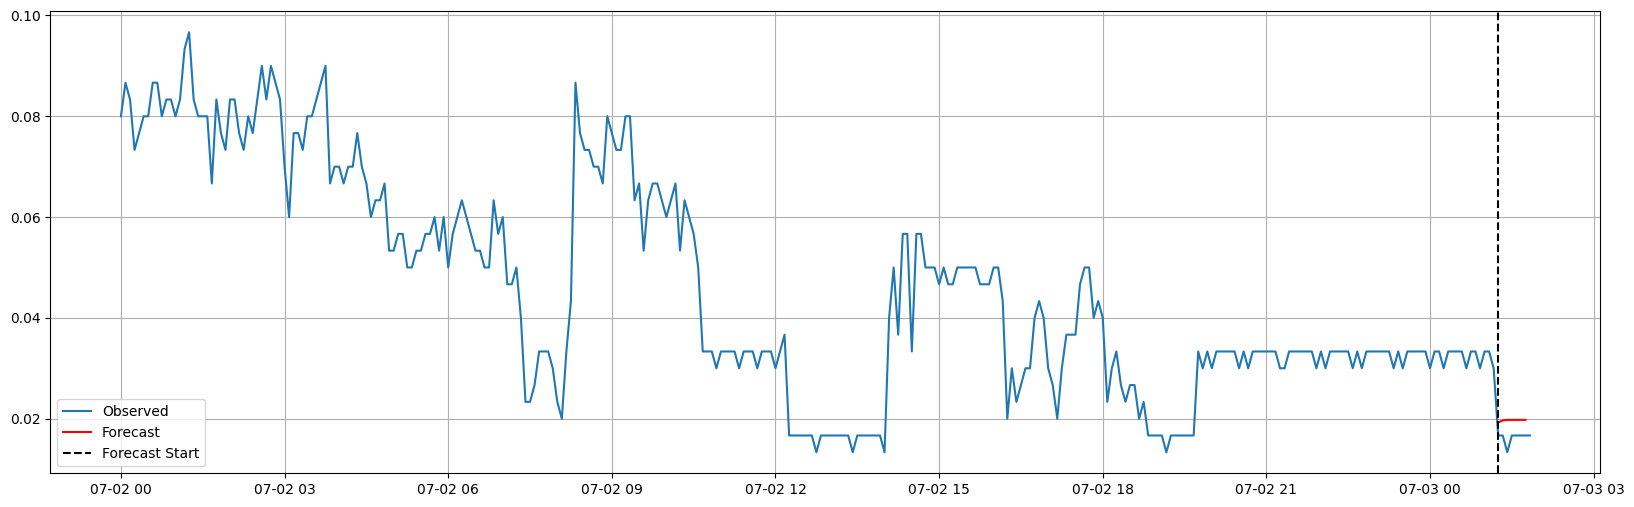

In [89]:
# Forecasting
forecast2 = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts2.index, ts2, label='Observed')
plt.plot(pd.date_range(trimmed_valid2.index[-1], periods=prediction_lenght, freq=freq), forecast2, label='Forecast', color='red')
plt.axvline(trimmed_valid2.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [90]:
print(forecast1)

237    0.156181
238    0.155864
239    0.155659
240    0.155525
241    0.155438
242    0.155381
243    0.155345
Name: predicted_mean, dtype: float64
